In [1]:
import numpy as np
from numpy import sin, cos,exp,pi
from time import process_time, time
from scipy.optimize import curve_fit, least_squares
from scipy.fft import fft,fftshift,fft2, fftfreq, ifft
from scipy.signal import oaconvolve, medfilt2d

from scipy.ndimage import rotate
from scipy.interpolate import interp1d

# import h5py
from skimage.transform import radon
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import transforms
from PIL import Image, ImageFilter
import joblib as jb
import tifffile as tfl
import os
from IPython.display import clear_output
import re
import pandas as pd

In [419]:
%run "C:\Users\gabri\Documents\Python Scripts\NPGMI-Library\NPGMI Base Code.ipynb"

In [3]:
MONO_DATA = np.genfromtxt("mono_contrast_data.csv", delimiter = ",").T
MONO_ERROR = abs(MONO_DATA[1] - (np.genfromtxt("mono_error.csv", delimiter = ",").T)[1])
BI_DATA = np.genfromtxt("bichromatic_from_paper.csv", delimiter = ",").T
BI_ERROR = abs(BI_DATA[1] - (np.genfromtxt("bi_error_paper.csv", delimiter = ",").T)[1])
POLY_DATA = np.genfromtxt("polychromatic_from_paper.csv", delimiter = ",").T
POLY_ERROR = abs(POLY_DATA[1] - (np.genfromtxt("poly_error_paper.csv", delimiter = ",").T)[1])

### SEM Profile Processing (needs incorporation to PGMI class)

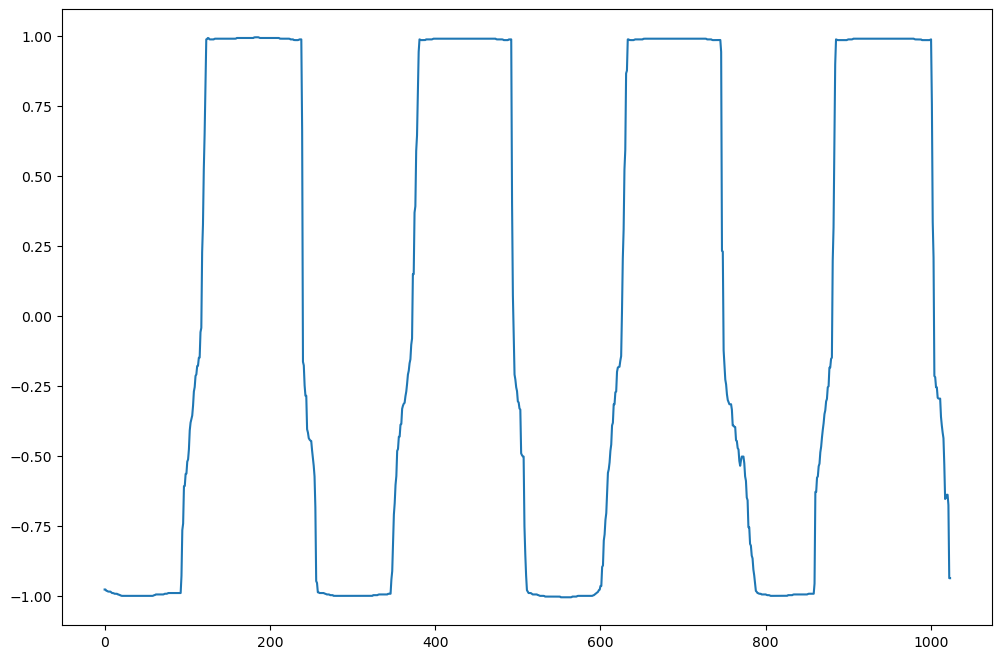

In [8]:


oldbbx,oldbbprofile = np.genfromtxt("oldbbprofile.csv", delimiter= ",")[:-2].T
n_periods = 4
uniquex, uniqueind = np.unique(oldbbx,return_index = True)
oldbbprofile = oldbbprofile[uniqueind]
oldbbsize = np.max(uniquex) - np.min(uniquex)

interpfuncbb = interp1d(uniquex, oldbbprofile)
bbx = np.linspace(np.min(uniquex), np.max(uniquex),1024)

bbprofile = interpfuncbb(bbx)
bbsize = np.max(bbx) - np.min(bbx)



# ftbb = np.abs(fft(exp(1j * phi2[19]/2 * bbprofile)))
# freqsbb = get_freqs(ftbb,bbsize)

# oldftbb = np.abs(fft(exp(1j * phi2[19]/2 * oldbbprofile)))
# oldfreqsbb = get_freqs(oldftbb,oldbbsize)

fig,ax1 = plt.subplots(figsize=(12,8))

# ax1.plot(oldbbprofile,"o-")
ax1.plot(bbprofile)


# ax1.plot(oldfreqsbb,oldftbb)
# ax1.plot(freqsbb,ftbb)
# ax1.set_xlim(-3e7,3e7)

plt.show()

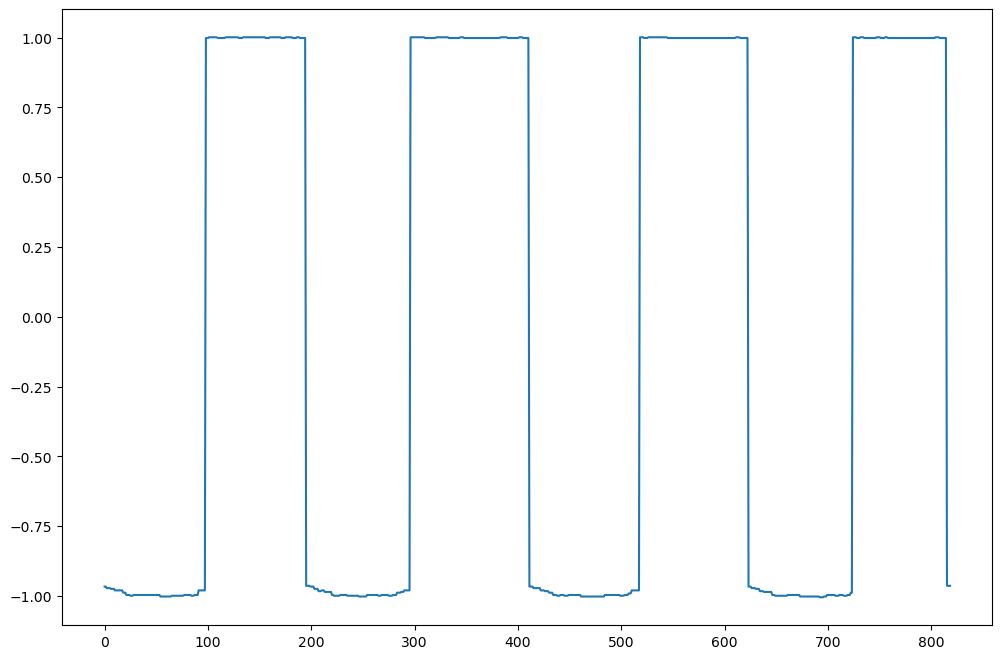

In [4]:
def smooth_profile(profile, pct_diff):
    for i in range(1,len(profile)-1):
        a,b,c = profile[i-1], profile[i], profile[i+1]
        if b != 0:
            if abs((b - a)/b) > (pct_diff/100.0) and abs((b- c)/b) > (pct_diff/100.0):
                profile[i] = (a+c)/2
    return profile


oldrectangulargx, oldrectangularprofile = np.genfromtxt("oldrectprofile.csv", delimiter = ",")[:-1].T

oldruniquex, oldruniqueind = np.unique(oldrectangulargx,return_index=True)
oldrectangularprofile = oldrectangularprofile[oldruniqueind]


oldrsize = np.max(oldruniquex) - np.min(oldruniquex) 


oldrprofile = smooth_profile(oldrectangularprofile, 50)



fig,ax1 = plt.subplots(figsize=(12,8))
ax1.plot(oldrprofile, "-")



plt.show()
plt.close(fig)

In [222]:

# fig,ax1 = plt.subplots(figsize=(12,8))
# gix,gi = np.linspace(0,rsize,len(rprofile)), grating_equation(np.linspace(0,rsize,len(rprofile)),p,-413*pi/440)

# ax1.plot(runiquex*1e6, h2/2*rprofile, label = "Rectangular Grating SEM")
# ax1.plot(gix*1e6,h2/2 *gi, label = "Ideal G(x)")

# ax1.set_xlabel(r"X-axis $(\mu m)$")
# ax1.set_ylabel(r"Z-axis $(\mu m)$")
# ax1.set_title("Comparison on SEM Grating to Ideal G(x)")



# ax1.legend()

# # fig.savefig("gratingFTcomparison.jpg")
# plt.show()
# plt.close(fig)

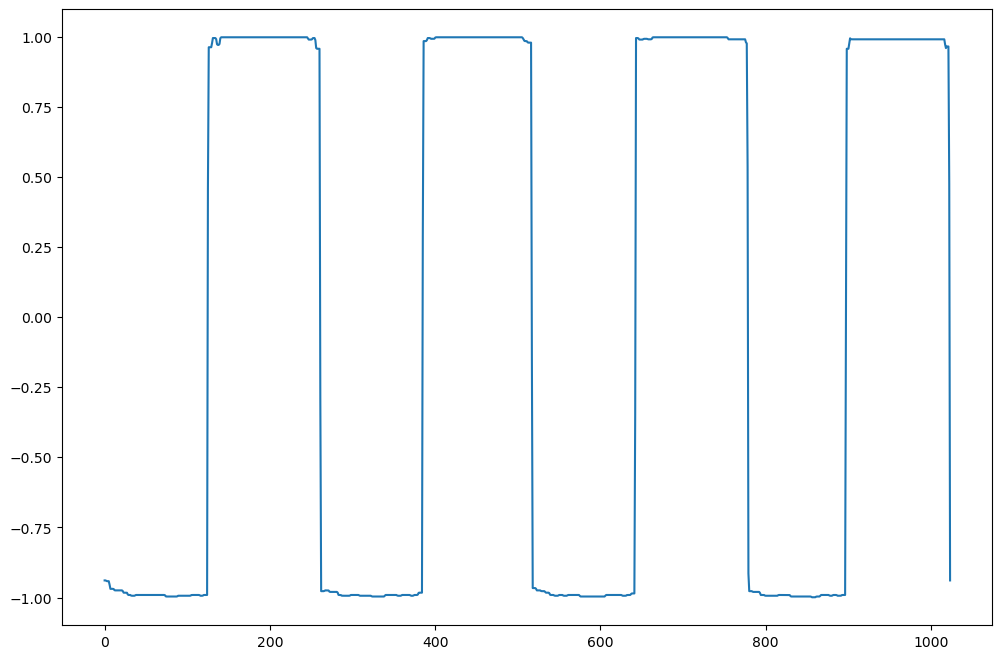

In [5]:
rx, rprofile = np.genfromtxt("rectprofile.csv", delimiter = ",")[:-1].T
rux, testind = np.unique(rx,return_index=True)
rprofile = smooth_profile(rprofile[testind],10)


rprofile[488:492] = 0.99
rprofile[560:576] = 0.99
rprofile[670:755] = 0.99


interpfuncr = interp1d(np.linspace(rux[0],rux[-1],len(rprofile)),rprofile)

rprofile = interpfuncr(np.linspace(rux[0],rux[-1],1024))

rsize = np.max(rux) - np.min(rux)


fig,ax1 = plt.subplots(figsize=(12,8))
ax1.plot(rprofile,"-")



# ftr = np.abs(fft(exp(1j*phi2[19]/2 * rprofile),norm = "forward"))
# freqsr = get_freqs(ftr,rsize)
# ax1.plot(freqsr,ftr)
# ax1.plot(freqsi, fti,label = "Ideal G(x)")
# plt.xlim(-3e7,3e7)


plt.show()
plt.close(fig)

### Rotation Testing

In [11]:

t0 = time()
# bbdeg = np.arange(3.9,4.2,0.05)
bbdeg = np.array([4.05])
# rdeg = np.arange(1,5,1)
rdeg = np.array([0])




RotatedBB = RotatedSpectrum(bbdeg,bbprofile,bbsize,h2,p)
RotatedRect = RotatedSpectrum(rdeg,rprofile,rsize,h1,p)

rotbbprofiles = RotatedBB.rotated_profiles
rotrprofiles = RotatedRect.rotated_profiles

print(time() - t0, "seconds")




2.1033260822296143 seconds


In [1155]:
bbdeg

array([4.05])

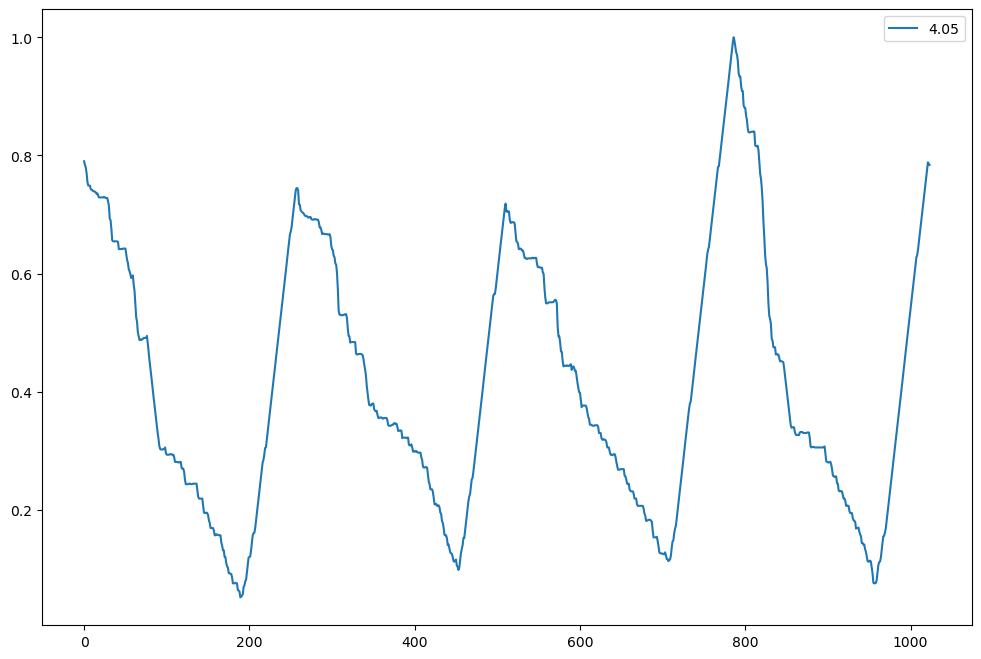

In [1156]:



fig,ax = plt.subplots(figsize = (12,8))

[ax.plot(rotbbprofiles[i], label = bbdeg[i]) for i,_ in enumerate(bbdeg)]
# ax.plot(rotbbprofiles[0])
# [ax.plot(rotrprofiles[i], label = rdeg[i]) for i,_ in enumerate(rdeg)]

# ax.plot(rotrprofiles[0])
# plt.xlim(0,3000)



ax.legend()
plt.show()


plt.close(fig)

In [203]:
lamindices = np.argmin(np.abs(lam[:,None] - np.arange(4,8,1)[None,:]*1e-10), axis = 0)

rotbbphi2, testprofile = force_broadcast(phi2,rotbbprofiles[0])
# print(lamindices)

bbfreq, bbft, bblocs = rect_spectrum(np.empty_like(bbprofile),bbsize,p,rotbbphi2,mt,bbprofile)
rotbbfreq, rotbbft, rotbblocs = rect_spectrum(np.empty_like(testprofile),bbsize,p,rotbbphi2,mt,testprofile)


fig,ax = plt.subplots(figsize = (12,8))
# ax.plot(bbx,testprofile.squeeze())
# ax.set_xlabel("Grating x-axis")
# ax.set_ylabel("Normalized height")
# ax.set_title("Bat Grating rotated %.1f degrees (Radon Transform)" % bbdeg)

ax.plot(bbfreq,np.abs(bbft[lamindices].T), label = (lam[lamindices]*1e10).round(2))
[ax.axvline(2*pi*m/p, color = "r" if m%2==0 else"k", ls = "--") for m in range(-mt,mt+1)]
ax.set_xlim(-5e7,5e7)
ax.set_ylim(0,0.15)


# ax.set_xlabel("Frequency")
# ax.set_ylabel("Amplitude")
# ax.set_title("FFT of Phase Profile of Bat Grating rotated %.1f degrees" % bbdeg)
# ax.legend(title = "Wavelengths in Å")
# fig.savefig("zoomedFTbbrotated4degwithlamdist.jpg")
# fig.savefig("bbrotated4deg.jpg")
# fig.savefig("zoomedFTwithdiffordbbunrotatedwithlamdist.jpg")


plt.show()
plt.close(fig)

ValueError: not enough values to unpack (expected 3, got 2)

ValueError: x and y must have same first dimension, but have shapes (1,) and (41, 5)

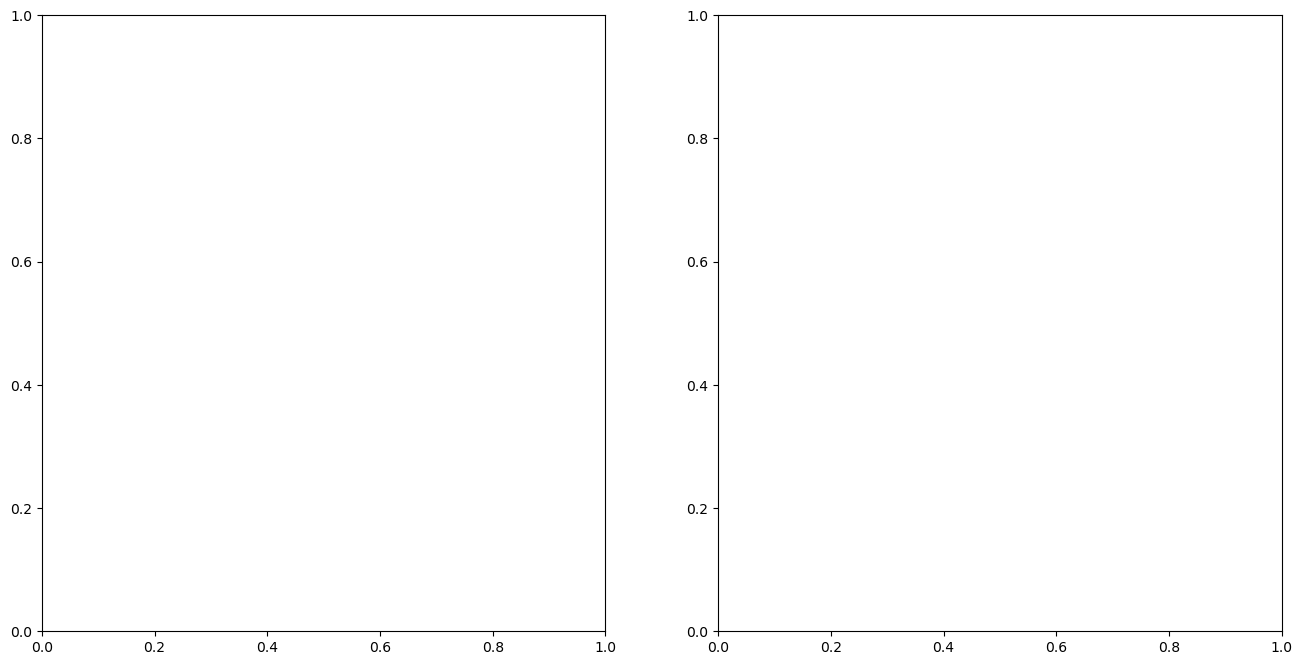

In [736]:
bbagfunclam = bbft[:,bblocs]

rotbbagfunclam = rotbbft[:,rotbblocs]


fig,(ax1, ax2) = plt.subplots(1,2,figsize = (16,8))
ax1.plot(lam*1e10,np.abs(rotbbagfunclam[:,:mt]), label = np.arange(-mt,mt+1)[:mt])
ax2.plot(lam*1e10,np.abs(rotbbagfunclam[:,mt:]), label = np.arange(-mt,mt+1)[mt:])

ax1.set_xlabel("Wavelength in Å")
ax1.set_ylabel("Absolute Amplitude")
ax1.set_title("(Negative orders) Amplitude vs. wavelength for bat grating rotated %.1f Degrees" % bbdeg)
ax1.legend(title = "Diffraction order")

ax2.set_xlabel("Wavelength in Å")
ax2.set_ylabel("Absolute Amplitude")
ax2.set_title("(Positive orders) Amplitude vs. wavelength for bat grating rotated %.1f Degrees" % bbdeg)
ax2.legend(title = "Diffraction order")
# fig.savefig("bbrotated4degamplitudeofdiffordsvslam.jpg")
plt.show()
plt.close(fig)

### Testing to determine 2D Grating Profile

In [45]:
# phi = pi/2
# p = 3e-6

# x,y = np.linspace(0,5*p,1001), np.linspace(0,5*p,1001)

# z = rect_spectrum2d(x,x[-1],y,y[-1],p,p,phi,5)

# # z = phi/2 * (np.sign(np.cos(2*pi*x[:,None]/p).round(10)) + np.sign(np.cos(2*pi*y[None,:]/p).round(10)) )
# # z[z < 0 ] = 0


# fig, ax1 = plt.subplots(figsize = (12,12))
# # c = ax1.imshow(z, aspect = "auto", extent = (x[0],x[-1],y[0],y[-1]))
# # c = ax1.imshow(abs(fftshift(fft2(exp(1j*z)))), aspect = "auto")
# ax1.imshow(z, origin = "lower")
# # fig.colorbar(c)

# # plt.xlim(0,50)
# # plt.ylim(0,50)
# # fig.savefig("fft2.jpg")

# plt.show()

### 2PGMI PhysRevA


In [1146]:
p = 2.4e-6
L1mono = 1.2
L1bi = 1.73
L1poly = 4.65

L0mono = -0.05
L0bi = 0.01
L0poly = 0.44

Lmono = 2.99 - L0mono
Lbi = 3.52 - L0bi
Lpoly = 8.8 - L0poly


polyspectrum = pd.read_excel("ng6_MCNP_spectrum.xlsx").to_numpy().T
polyspectrum[0]*=1e-9

lammono = np.array([4.4e-10])
plammono = np.array([1])

lambi = np.array([4.4e-10,2.2e-10])
plambi = np.array([3.2/4.2,1/4.2])

lampoly, plampoly = polyspectrum.copy()


mt = 5
x0 = np.array([0])

Nbc = 5e28*4.149e-15
h = 0.27*pi / (Nbc*4.4e-10)
hpoly = 0.2*pi / (Nbc*5e-10)

phimono = Nbc*lammono*h
phibi = Nbc*lambi*h

phipoly = Nbc*lampoly*hpoly


camsize = 2.5e-2
slitx = 230e-6
# slitxrange = np.linspace(180,300,13)*1e-6
slitxpoly = 590e-6
# slitxpolyrange = np.linspace(450,600,16)*1e-6


slity = 100e-6
xbin = 1e-6
ybin = 1e-6
res = 100e-6
respoly = 150e-6


G1sdmono = {"p":p, "L1": np.array([L1mono]), "phi":phimono}
G1sdmono["L2"] = np.linspace(7,16,19)*1e-3 + d0["mono"]


G2sdmono = {"p":p, "L1": G1sdmono["L1"] +  G1sdmono["L2"], "phi":phimono}
G2sdmono["L2"] = Lmono - (G1sdmono["L1"] + G1sdmono["L2"])

G1sdbi = {"p":p, "L1": np.array([L1bi]), "phi":phibi}
G1sdbi["L2"] = np.linspace(7,16,10)*1e-3 + d0["bi"]


G2sdbi = {"p":p, "L1": G1sdbi["L1"] +  G1sdbi["L2"], "phi":phibi}
G2sdbi["L2"] = Lbi - (G1sdbi["L1"] + G1sdbi["L2"])


G1sdpoly = {"p":p, "L1": np.array([L1poly]), "phi":phipoly}
G1sdpoly["L2"] = np.linspace(7,16,10)*1e-3 + d0["poly"]


G2sdpoly = {"p":p, "L1": G1sdpoly["L1"] +  G1sdpoly["L2"], "phi":phipoly}
G2sdpoly["L2"] = Lpoly - (G1sdpoly["L1"] + G1sdpoly["L2"])


# Ioff = np.linspace(-5000,5000,10)
simaptsmono = {"G1":RectGrating(G1sdmono),"G2":RectGrating(G2sdmono)}
siminitmono = {"lam":lammono, "plam": plammono, "L":Lmono,"d":G1sdmono["L2"],"mt":mt, "x": np.linspace(0,camsize,int(camsize/xbin)),"x0" : x0,"xbin":xbin,"ybin":ybin,\
           "pos":np.array([[0],[1]]) ,"camsize" : camsize ,"convmode" : "valid", "slitx": slitx, "slity" : slity, "res": res, "batches" : 2000}

simaptsbi = {"G1":RectGrating(G1sdbi),"G2":RectGrating(G2sdbi)}
siminitbi = {"lam":lambi, "plam": plambi, "L":Lbi,"d":G1sdbi["L2"],"mt":mt, "x": np.linspace(0,camsize,int(camsize/xbin)),"x0" : x0,"xbin":xbin,"ybin":ybin,\
           "pos":np.array([[0],[1]]) ,"camsize" : camsize ,"convmode" : "valid", "slitx": slitx, "slity" : slity, "res": res, "batches" : 2000}

simaptspoly = {"G1":RectGrating(G1sdpoly),"G2":RectGrating(G2sdpoly)}
siminitpoly = {"lam":lampoly, "plam": plampoly, "L":Lpoly,"d":G1sdpoly["L2"],"mt":mt, "x": np.linspace(0,camsize,int(camsize/xbin)),"x0" : x0,"xbin":xbin,"ybin":ybin,\
           "pos":np.array([[0],[1]]) ,"camsize" : camsize ,"convmode" : "valid", "slitx": slitxpoly, "slity" : slity, "res": respoly, "batches" : 2000}


In [1147]:
t0 = time()

simmono = PGMI(simaptsmono,siminitmono)
simmono.propagate_to("G1")
simmono.propagate_to("G2")
simmono.generate_after("G2")

simbi = PGMI(simaptsbi,siminitbi)
simbi.propagate_to("G1")
simbi.propagate_to("G2")
simbi.generate_after("G2")

simpoly = PGMI(simaptspoly,siminitpoly)
simpoly.propagate_to("G1")
simpoly.propagate_to("G2")
simpoly.generate_after("G2")

print(time() - t0, "seconds")


0.00023
(2000, 19, 12) after parallel
(19, 24000) after reshape
(19, 24000) before convolution
Finding contrast
0.00023
(2000, 10, 2, 12) after parallel
(10, 2, 24000) after reshape
(10, 24000) before convolution
Finding contrast
0.00059
(2000, 10, 41, 12) after parallel
(10, 41, 24000) after reshape
(10, 24000) before convolution
Finding contrast
49.88754224777222 seconds


In [1148]:
monocont = simmono.get_value("contrast")
bicont = simbi.get_value("contrast")
polycont = simpoly.get_value("contrast")

monofitparams = simmono.get_value("fitparams")
bifitparams = simbi.get_value("fitparams")
polyfitparams = simpoly.get_value("fitparams")

### 3PGMI PRL 

In [12]:

p = 2.4e-6
L = 8.8

lam = np.array([5e-10])
plam = np.array([1])

polyspectrum = pd.read_excel("ng6_MCNP_spectrum.xlsx").to_numpy().T
polyspectrum[0]*=1e-9
# lam,plam = polyspectrum.copy()

x0 = np.array([0])



mt = 1


Nbc = 5e28*4.149e-15
h1,h2,h3 = 15.8e-6,29e-6,15.8e-6

phi1,phi2,phi3 = Nbc*lam*h1,Nbc*lam*h2,Nbc*lam*h3
idealgrating_phase_offset = -413*pi/440


camsize = 2.5e-2
slitx = 500e-6
slity = 100e-6

xbin = 1e-6
ybin = 25e-6

res = 150e-6
d1 = 4.6e-2
L1 = 4.75

G1sd = {"p":p, "L1": np.array([L1-d1]), "phi":phi1, "phase_offset": idealgrating_phase_offset}
G1sd["L2"] = np.array([d1])

G2sd = {"p":p, "L1": G1sd["L2"] + G1sd["L1"], "phi":phi2, "phase_offset": idealgrating_phase_offset}


G2sd["L2"] = np.linspace(2,7,101)*1e-2 
# G2sd["L2"] = np.array([-1.2,-1,-0.8,0.8,1,1.2])*1e-2 + d1

G2sd["L2"][G2sd["L2"] == d1] = d1 + 5e-5

G3sd = {"p":p, "L1": G2sd["L2"] + G2sd["L1"], "phi":phi3, "phase_offset": idealgrating_phase_offset}
G3sd["L2"] = np.array([L]) - G3sd["L1"] 

simaptsideal = {"G1":RectGrating(G1sd),"G2":RectGrating(G2sd),"G3":RectGrating(G3sd)}


simaptsrect = {"G1":GratingFromImage(np.empty_like(rprofile),G1sd, rsize, rprofile),\
                      "G2":GratingFromImage(np.empty_like(rprofile),G2sd,rsize,rprofile),\
           "G3":GratingFromImage(np.empty_like(rprofile),G3sd,rsize, rprofile)}



simaptsbb = {"G1":GratingFromImage(np.empty_like(rprofile),G1sd, rsize, rprofile),\
                      "G2":GratingFromImage(np.empty_like(rotbbprofiles),G2sd,bbsize,rotbbprofiles[0]),\
           "G3":GratingFromImage(np.empty_like(rprofile),G3sd,rsize, rprofile)}







siminit = {"lam":lam, "plam":plam, "L":L,"d":G2sd["L2"]-d1,"mt":mt, "x": np.linspace(0,camsize,int(camsize/xbin)),"x0" : x0,"xbin":xbin,"ybin":ybin ,"pos":np.array([[0],[1]]),\
           "camsize" : camsize ,"convmode" : "valid", "slitx": slitx,"slity" : slity, "res": res, "batches" : 12500  }

In [1292]:
t0 = time()

simrect = PGMI(simaptsrect,siminit)
simrect.propagate_to("G1")
simrect.propagate_to("G2")
simrect.propagate_to("G3")
simrect.generate_after("G3")


# simbb = PGMI(simaptsbb,siminit)
# simbb.propagate_to("G1")
# simbb.propagate_to("G2")
# simbb.propagate_to("G3")
# simbb.generate_after("G3")

print(time() - t0, "seconds")


(12500, 101, 2) after parallel
(101, 25000) after reshape
(101, 25000) before convolution
Finding contrast
80.40763807296753 seconds


In [818]:
t0 = time()

# simideal = PGMI(simaptsideal,siminit)
# simideal.propagate_to("G1")
# simideal.propagate_to("G2")
# simideal.propagate_to("G3")
# simideal.generate_after("G3")




I3bbdeg, cont3bbdeg, fitparamsbbdeg = [],[],[]

# for rotbbprofile in rotbbprofiles:
    
#     for d2 in np.linspace(2,7,51)*1e-2 : 
    
    
#         G1sd = {"p":p, "L1": np.array([L1-d1]), "phi":phi1, "phase_offset": idealgrating_phase_offset}
#         G1sd["L2"] = np.array([d1])

#         G2sd = {"p":p, "L1": G1sd["L2"] + G1sd["L1"], "phi":phi2, "phase_offset": idealgrating_phase_offset}


#         G2sd["L2"] = np.array([d2])

#         G2sd["L2"][G2sd["L2"] == d1] = d1 + 5e-5

#         G3sd = {"p":p, "L1": G2sd["L2"] + G2sd["L1"], "phi":phi3, "phase_offset": idealgrating_phase_offset}
#         G3sd["L2"] = np.array([L]) - G3sd["L1"] 

    

#         simaptsbb = {"G1":GratingFromImage(np.empty_like(rprofile),G1sd, rsize, rprofile),\
#                               "G2":GratingFromImage(np.empty_like(rotbbprofiles),G2sd,bbsize,rotbbprofiles),\
#                    "G3":GratingFromImage(np.empty_like(rprofile),G3sd,rsize, rprofile)}




#         siminit = {"lam":lam, "plam":plam, "L":L,"d":G2sd["L2"]-d1,"mt":mt, "x": np.linspace(0,camsize,int(camsize/xbin)),"x0" : x0,"xbin":xbin,"ybin":ybin ,"pos":np.array([[0],[1]]),\
#                    "camsize" : camsize ,"convmode" : "valid", "slitx": slitx,"slity" : slity, "res": res, "batches" : 6250  }
        
#         simaptsbb["G2"].profile = np.array(rotbbprofile)
#         simbb = PGMI(simaptsbb,siminit)
#         simbb.propagate_to("G1")
#         simbb.propagate_to("G2")
#         simbb.propagate_to("G3")
#         simbb.generate_after("G3")
#         I3bbdeg.append(simbb.get_value("intensity"))
#         cont3bbdeg.append(simbb.get_value("contrast"))
#         fitparamsbbdeg.append(simbb.get_value("fitparams"))
    
    
# I3bbdeg5, cont3bbdeg5, fitparamsbbdeg5 = [],[],[]

# for rotrprofile in rotrprofiles:
#     simaptsbb["G1"].profile = rotrprofile
#     simaptsbb["G3"].profile = rotrprofile
#     simbb = PGMI(simaptsbb,siminit)
#     simbb.propagate_to("G1")
#     simbb.propagate_to("G2")
#     simbb.propagate_to("G3")
#     simbb.generate_after("G3")
#     I3bbdeg5.append(simbb.get_value("intensity"))
#     cont3bbdeg5.append(simbb.get_value("contrast"))
#     fitparamsbbdeg5.append(simbb.get_value("fitparams"))



print(time() - t0, "seconds")


(12500, 41, 2) after parallel
(41, 25000) after reshape
(25000,) before convolution
Finding contrast
23676.881770133972 seconds


In [1293]:
# I3ideal = simideal.get_value("intensity")
# cont3ideal = simideal.get_value("contrast")
# fitparams3ideal = simideal.get_value("fitparams")



I3monorect = simrect.get_value("intensity")
cont3monorect = simrect.get_value("contrast")
fitparams3monorect = simrect.get_value("fitparams")
freq3monorect = abs(1/fitparams3monorect[...,2])/1000




# I3bb = simbb.get_value("intensity")
# cont3bb = simbb.get_value("contrast")
# fitparams3bb = simbb.get_value("fitparams")
# freq3bb = abs(1/fitparams3bb[...,2])/1000




# I3ideal5 = simideal.get_value("intensity")
# cont3ideal5 = simideal.get_value("contrast")
# fitparams3ideal5 = simideal.get_value("fitparams")



# I3monorect5 = simrect.get_value("intensity")
# cont3monorect5 = simrect.get_value("contrast")
# fitparams3monorect5 = simrect.get_value("fitparams")
# freq3monorect5 = abs(1/fitparams3monorect[...,2])/1000

# I3polyrect5 = simrect.get_value("intensity")
# cont3polyrect5 = simrect.get_value("contrast")
# fitparams3polyrect5 = simrect.get_value("fitparams")
# freq3polyrect5 = abs(1/fitparams3polyrect5[...,2])/1000



# I3bb5 = simbb.get_value("intensity")
# cont3bb5 = simbb.get_value("contrast")
# fitparams3bb5 = simbb.get_value("fitparams")



### 2PGMI Plots

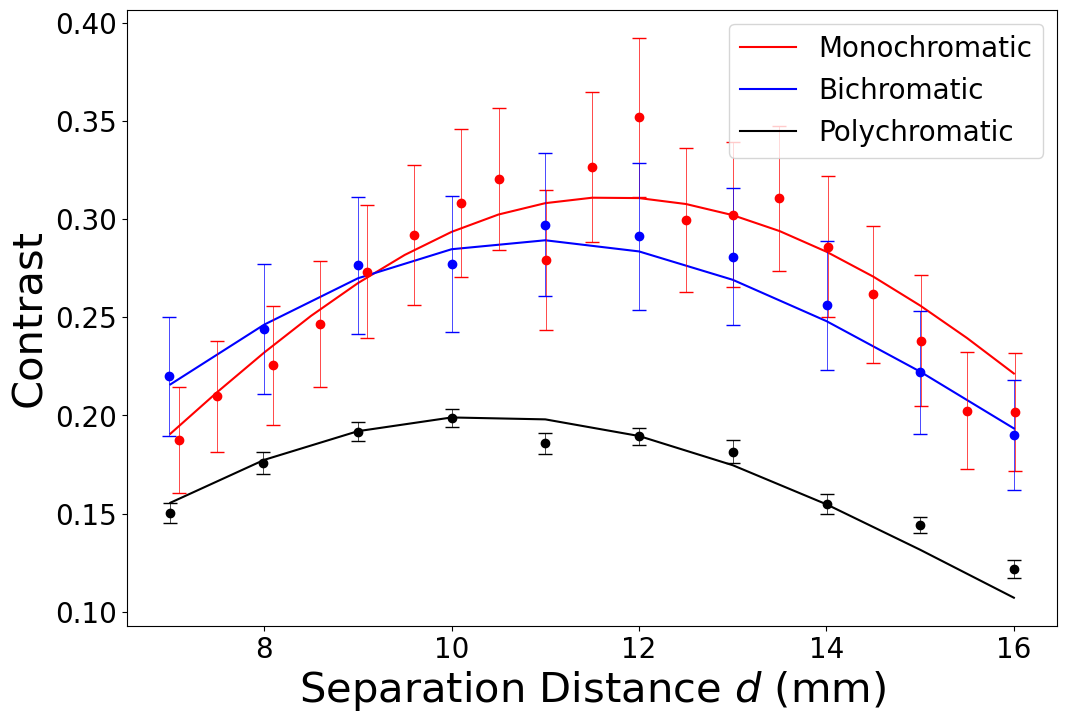

In [1150]:
fig, ax1 = plt.subplots(figsize  = (12,8))

d0 = {"mono": -0.75e-3, "bi": +0.8e-3, "poly": -0.38e-3}
colours = ["red","blue", "black"]

ax1.plot((simmono.d - d0["mono"])*1e3, monocont, color = colours[0], label = r"Monochromatic")
ax1.plot((simbi.d -d0["bi"])*1e3, bicont, color = colours[1], label = r"Bichromatic")

ax1.plot((simpoly.d-d0["poly"] )*1e3, polycont, color = colours[2], label = r"Polychromatic")

plt.gca().set_prop_cycle(None)

ax1.errorbar(MONO_DATA[0],MONO_DATA[1],MONO_ERROR, fmt = "ro", elinewidth = 0.5,capsize = 5)
ax1.errorbar(BI_DATA[0]*1e3,BI_DATA[1],BI_ERROR, fmt = "bo", elinewidth = 0.5,capsize = 5)
ax1.errorbar(POLY_DATA[0]*1e3,POLY_DATA[1],POLY_ERROR, fmt = "ko", elinewidth = 0.5,capsize = 5)

# ax1.axvline((p**2/5e-10)* 1e3, label = "Predicted max")

ax1.legend(fontsize = 20, loc = "upper right")
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

ax1.set_xlabel("Separation Distance $d$ (mm)", fontsize = 30)
ax1.set_ylabel("Contrast", fontsize = 30)
# ax1.set_title("Contrast vs. G1-G2 Separation, %d diffraction order%s" % (mt, "s" if mt > 1 else ""))
# fig.savefig("2PGMIContrastVsDsliterrorminimized.png")
# ax1.set_xlim(0.55,9)
# plt.grid()
plt.show()
plt.close(fig)

In [1105]:
# fig, ax1 = plt.subplots(figsize  = (12,8))

# ax1.plot(simtest.d*1e3, 1/(monofitparams[:,2]*1e3), label = "monochromatic simulation fitting")

# ax1.plot(simtest.d*1e3, 1/(bifitparams[:,2]*1e3), label = "bichromatic simulation fitting")

# ax1.plot(simtest.d*1e3, 1/(polyfitparams[:,2]*1e3), label = "polychromatic simulation fitting")


# ax1.legend()

# ax1.set_xlabel("d")
# ax1.set_ylabel("Frequency")
# ax1.set_title("Frequency vs. d, %d diffraction order%s" % (mt, "s" if mt > 1 else ""))
# plt.show()

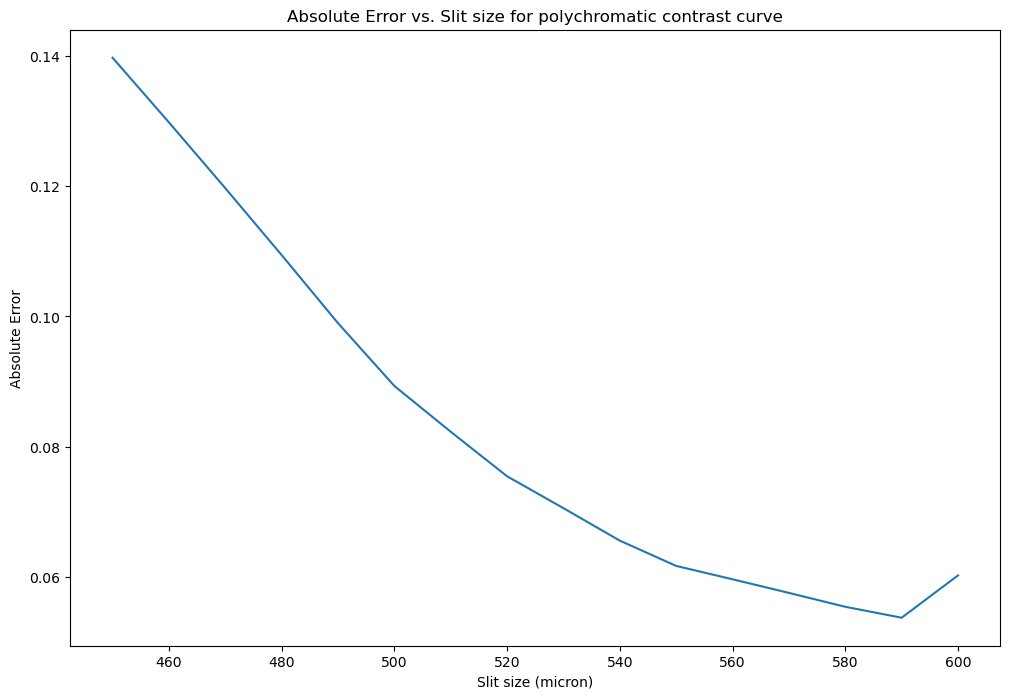

In [ ]:
fig, ax1 = plt.subplots(figsize  = (12,8))

ax1.plot(slitxpolyrange*1e6,np.sum(polysliterr, axis = -1) )

ax1.set_xlabel("Slit size (micron)")
ax1.set_ylabel("Absolute Error")
ax1.set_title("Absolute Error vs. Slit size for polychromatic contrast curve")
# fig.savefig("errorvsslit2pgmipoly.jpg")
plt.show()
plt.close(fig)

### 3PGMI Plots

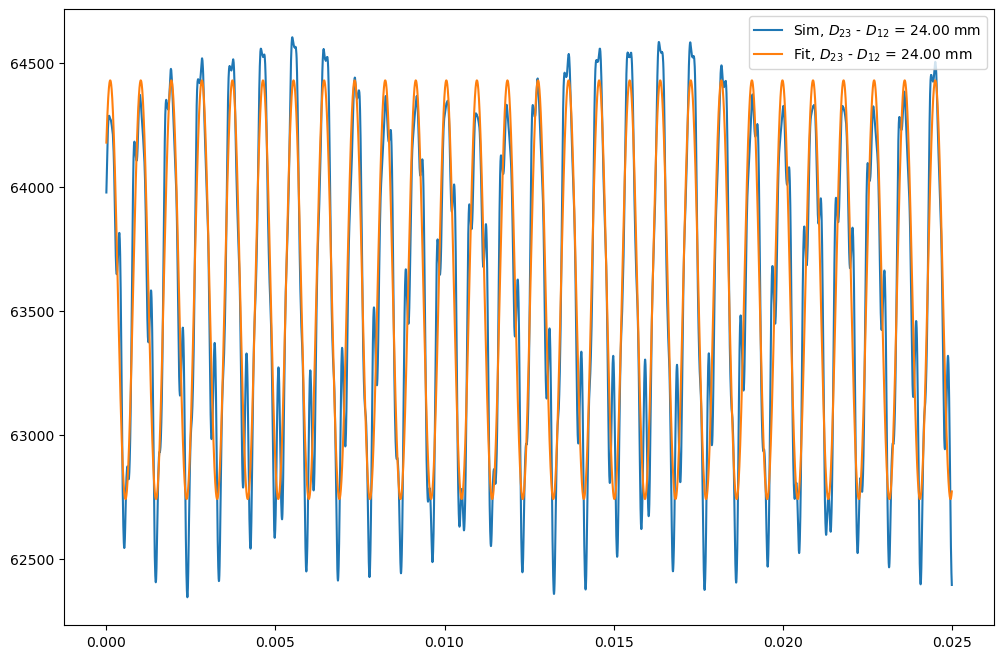

In [1283]:
theorycurves = []

# for ind in range(I3bb5.shape[0]):

# for ind in range(I3bbdeg.shape[0]):
#     # print(ind)
#     fig, ax1 = plt.subplots(figsize  = (12,8))
#     clear_output(wait= True)
# #     theorycurve = cosine_func(simbb.x, np.mean(I3bb[ind]), np.amax(I3bb[ind]) - np.mean(I3bb[ind]),\
# #                                            L*p/simbb.d[ind],0)
#     ax1.plot(simbb.x,I3bbdeg[ind], label = "Sim, $D_{23}$ - $D_{12}$ = %.2f mm" % (siminit["d"][ind]*1e3))
#     ax1.plot(simbb.x,cosine_func(simbb.x, *fitparamsbbdeg[ind]), label = "Fit, $D_{23}$ - $D_{12}$ = %.2f mm" % (siminit["d"][ind]*1e3))
# #     ax1.plot(simbb.x, theorycurve, label = "Theory, $D_{23}$ - $D_{12}$ = %.2f mm" % (simbb.d[ind]*1e3) )
# #     theorycurves.append(theorycurve)
#     ax1.legend()
#     # ax1.set_xlim(5e-3,10e-3)
#     ax1.set_ylim()

#     plt.pause(0.5)
# #     ax1.cla()
#     plt.show()
#     plt.close(fig)
    
    

    
for ind in range(I3polyrect5.shape[0]):
    fig, ax1 = plt.subplots(figsize  = (12,8))
    clear_output(wait= True)
#     theorycurve = cosine_func(simideal5.x, np.mean(I3ideal5[ind]), np.amax(I3ideal5[ind]) - np.mean(I3ideal5[ind]),\
#                                            L*p/simideal5.d[ind],0)
    ax1.plot(simrect.x,I3polyrect5[ind], label = "Sim, $D_{23}$ - $D_{12}$ = %.2f mm" % (simrect.d[ind]*1e3))
    ax1.plot(simrect.x,cosine_func(simrect.x, *fitparams3polyrect5[ind]), label = "Fit, $D_{23}$ - $D_{12}$ = %.2f mm" % (simrect.d[ind]*1e3))
#     ax1.plot(simideal5.x, theorycurve, label = "Theory, $D_{23}$ - $D_{12}$ = %.2f mm" % (simideal5.d[ind]*1e3) )
#     theorycurves.append(theorycurve)
    ax1.legend()
    
    plt.pause(0.1)
#     ax1.cla()

    plt.show()
    plt.close(fig)

In [250]:
# fitparams3bb5[18]

array([ 6.43446035e+04,  2.07950915e+03, -1.66464507e-03, -2.29575296e+00])

[ 6.41801691e+04  9.69139455e+03 -1.84021098e-03  2.57231240e+00]


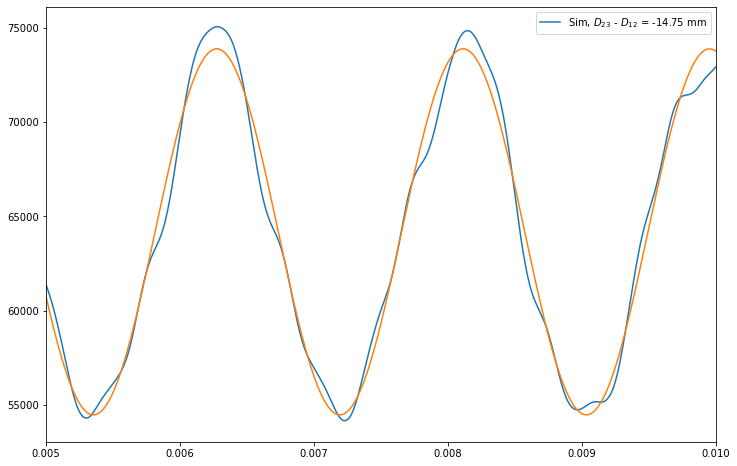

In [253]:
# fig, ax1 = plt.subplots(figsize  = (12,8))
# ax1.plot(simbb.x,I3bb5[18], label = "Sim, $D_{23}$ - $D_{12}$ = %.2f mm" % (simbb.d[18]*1e3))
# # ax1.plot(simbb.x,cosine_func(simbb.x, *fitparams3bb5[ind]), label = "Fit, $D_{23}$ - $D_{12}$ = %.2f mm" % (simbb.d[ind]*1e3))

# fit, _  = curve_fit(cosine_func, simbb.x, I3bb5[18],p0 = [np.mean(I3bb5[18]), np.max(I3bb5[18]) - np.mean(I3bb5[18]), 1.3*L*p/simbb.d[18], 3*pi/4 ])
# print(fit)
# ax1.plot(simbb.x,cosine_func(simbb.x,*fit))

# ax1.legend()
# ax1.set_xlim(5e-3,10e-3)
# ax1.set_ylim()
# plt.show()
# plt.close(fig)

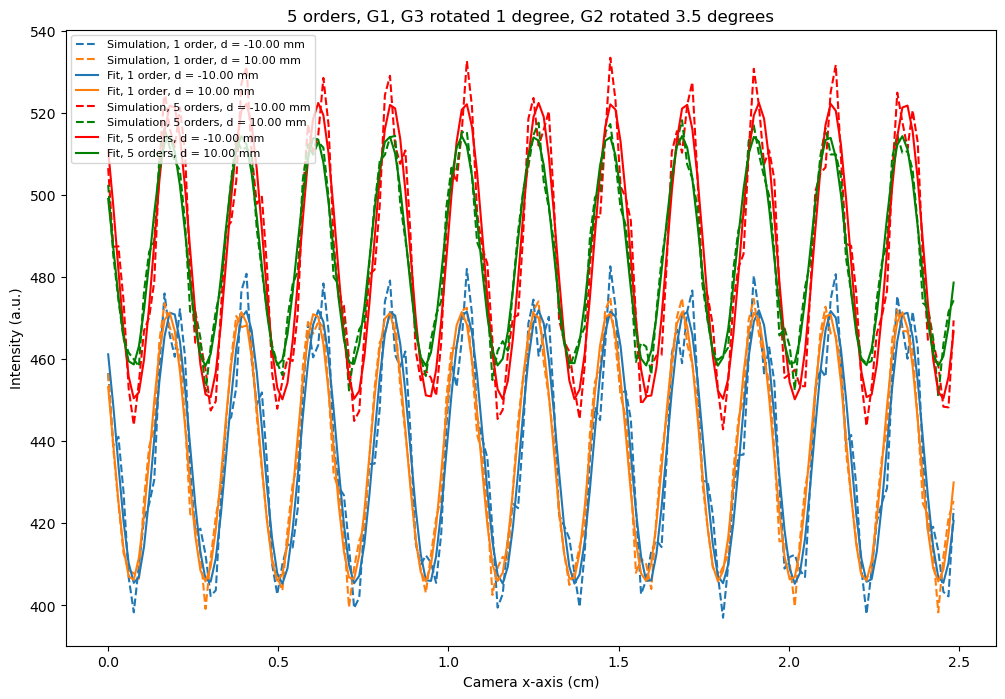

In [1857]:
I3bbdeg, cont3bbdeg, fitparamsbbdeg = np.array(I3bbdeg).squeeze(), np.array(cont3bbdeg).squeeze(), np.array(fitparamsbbdeg).squeeze()
I3bbdeg5, cont3bbdeg5, fitparamsbbdeg5 = np.array(I3bbdeg5).squeeze(), np.array(cont3bbdeg5).squeeze(), np.array(fitparamsbbdeg5).squeeze()



fig, ax1 = plt.subplots(figsize  = (12,8))

[ax1.plot(simbb.x*1e2,I3bbdeg[0,i],"--", label = "Simulation, 1 order, d = %.2f mm" % ( simbb.d[i] * 1e3)) for i in [1,-2] ]
ax1.set_prop_cycle(None)
[ax1.plot(simbb.x*1e2,cosine_func(simbb.x,*fitparamsbbdeg[0,i]), label = "Fit, 1 order, d = %.2f mm" % ( simbb.d[i] * 1e3)) for i in [1,-2] ]

ax1.set_prop_cycle(color = ['red','green'])
[ax1.plot(simbb.x*1e2,np.array(I3bbdeg5)[0,i] ,"--", label = "Simulation, 5 orders, d = %.2f mm" % (simbb.d[i] * 1e3)) for i in [1,-2] ]
ax1.set_prop_cycle(color = ['red','green'])
[ax1.plot(simbb.x*1e2,cosine_func(simbb.x,*fitparamsbbdeg5[0,i]) , label = "Fit, 5 orders, d = %.2f mm" % (simbb.d[i] * 1e3)) for i in [1,-2] ]


ax1.legend(fontsize ="8")
ax1.set_xlabel("Camera x-axis (cm)")
ax1.set_ylabel("Intensity (a.u.)")
ax1.set_title("5 orders, G1, G3 rotated 1 degree, G2 rotated 3.5 degrees")
plt.show()

# fig.savefig("comparerotationsnewbinning.jpg")
plt.close(fig) 

In [1170]:
prld, prlcont = np.genfromtxt("PRLPOLYCONTDATA.csv",delimiter=",").T
prlfreq = np.genfromtxt("PRLFREQDATA.csv").T[1]

In [1190]:
# cont3bb[42] = 0
# cont3ideal5[41] = 0
# cont3rect5[40:43] = 0
# cont3bb5[41]= 0
# cont3bbdeg[:,52:54] = 0
# I3bbdeg, cont3bbdeg, freqbbdeg = np.array(I3bbdeg), np.array(cont3bbdeg), abs(1/np.array(fitparamsbbdeg)[...,2]/1000)
# freqbbdeg[0,51] = 0
cont3bb[26] = 0

In [1296]:
cont3monorect[52] = 0
cont3monorect5[52] = 0
cont3polyrect5[52] = 0

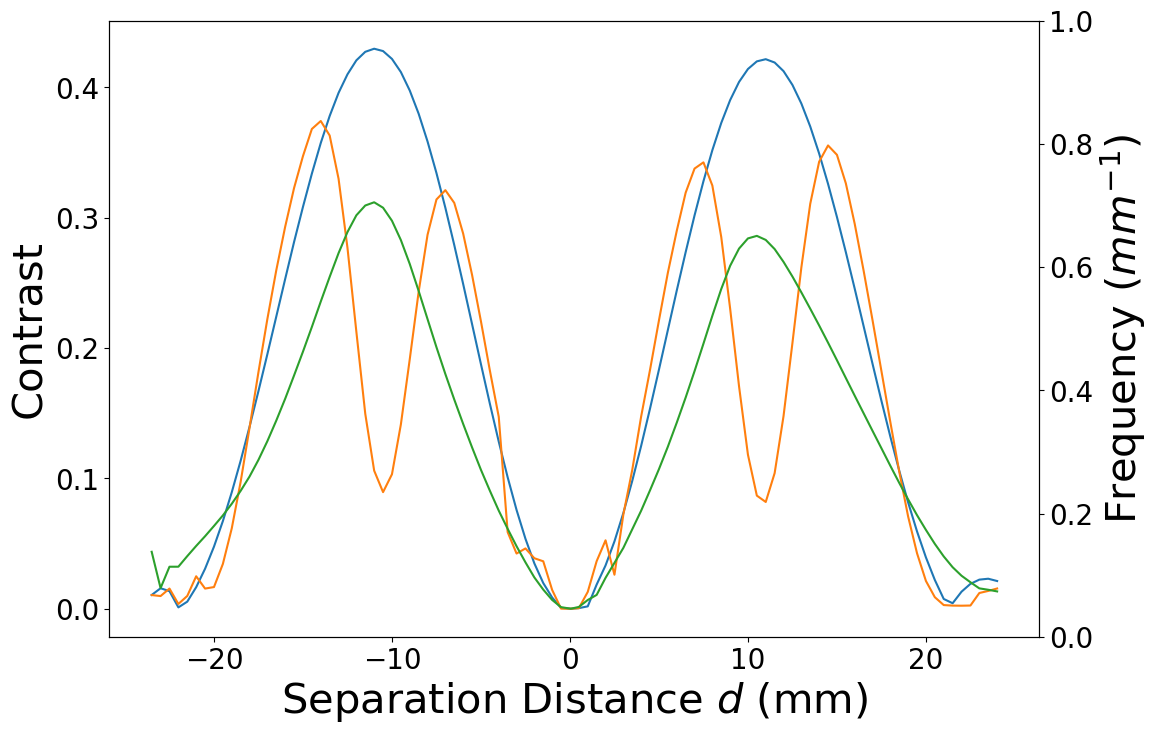

In [1300]:
fig, ax1 = plt.subplots(figsize  = (12,8))


ax1.plot(simrect.d[5:]*1e3, cont3monorect[5:], label = "Monochromatic, 1 order")


# ax1.plot(simbb.d[5:-3]*1e3, cont3bb[5:-3],"r-", label = "G2 rotated %.2f degrees" % abs(bbdeg))


ax1.plot(simrect.d[5:]*1e3, cont3monorect5[5:], label = "Monochromatic, 5 orders")
ax1.plot(simrect.d[5:]*1e3, cont3polyrect5[5:], label = "Polychromatic, 5 orders")


# ax1.plot(simbb.d[8:-4]*1e3, cont3bb5[8:-4], label = "5 order Bat rotated %.1f degrees" % abs(bbdeg))



# ax1.plot(prld,prlcont, "rx", label = "Data")
# ax1.set_ylim(0,0.04)



ax2 = ax1.twinx()


# ax2.plot(simrect.d[5:-4]*1e3, freq3monorect[5:-4], label = "All Rectangular Gratings")

# ax2.plot(simrect.d[5:-3]*1e3, freq3monorect5[5:-3], label = "All Rectangular Gratings")


# ax2.plot(simbb.d[5:-3]*1e3, freq3bb[5:-3], "b-",  label = "G2 rotated %.2f degrees" % abs(bbdeg))


# ax2.plot(simrect.d*1e3, abs(1/fitparams3rect5[:,2]) / (1000), "o", label = "All Rectangular Gratings")




# ax2.plot(prld,prlfreq, "bo", label = "Experimental Data")


# ax2.plot(simbb.d*1e3, abs(simbb.d / (L*p*1e3)), label = r"$\frac{d}{Lp}$")

# ax1.legend(loc = "upper center", fontsize = 15)
# ax2.legend(loc = "upper left", fontsize = 20)

ax1.set_xlabel("Separation Distance $d$ (mm)", fontsize = 30)
ax1.set_ylabel("Contrast", fontsize = 30)
ax2.set_ylabel(r"Frequency $(mm^{-1})$", fontsize = 30)
# ax1.set_title("Contrast vs. G2-G3 Separation, %d diffraction order%s" % (mt, "s" if mt > 1 else ""))
ax1.tick_params(labelsize = 20)
ax2.tick_params(labelsize = 20)


fig.savefig("3PGMIrectmonoandpoly1and5orders.png")

plt.show()
plt.close(fig)

### JPARC Data Analysis

In [66]:
def process_tfl(imgarr, rot_deg, medfilt_window):
    imgarr[~np.isfinite(imgarr)] = 0
    ycut,xcut = (np.array(imgarr.shape) * np.tan(np.radians(rot_deg))).astype(int)
    return medfilt2d(np.array(Image.fromarray(imgarr).rotate(rot_deg))[ycut:imgarr.shape[0] - ycut, xcut:imgarr.shape[1] - xcut],medfilt_window)

In [67]:
t0 = time()

exp1path = r"C:\Users\gabri\Documents\Python Scripts\JPARC experiment\exp1"

image_side = 2048


cm_per_pixel = 6/1944 # 6.32 cm camera total
rotdegs = [1.2,1,1,1,0.3,0]

# xlen_pxl, ylen_pxl = 750, 200

# regions_coords = np.array([[200,950,0,200], [image_side - 950, image_side - 200,0,200], [200,950,image_side - 200, image_side],\
#                   [image_side - 950,image_side-200, image_side - 200,image_side],[(image_side - 750)//2,  (image_side + 750)//2,(image_side - 200)//2, (image_side + 200)//2]])
# allfiltregions = []


# for i, coords in enumerate(regions_coords):
#     xstart,xend,ystart,yend = coords
#     allfiltregions.append([])
#     for j, path in enumerate(os.listdir(exp1path)):
#         allfiltregions[-1].append([process_tfl(img, rotdeg, 5) for img in np.array(tfl.imread(exp1path  + "\\" + path ))[...,ystart:yend,xstart:xend]]) 

# allfiltregions = np.array(allfiltregions)

# exp1region = np.array([np.array(tfl.imread(exp1path  + "\\" + i ))[...,ystart:yend,xstart:xend] for i in os.listdir(exp1path)])

# # exp1region = np.array([np.array(tfl.imread(exp1path  + "\\" + i )) for i in os.listdir(exp1path)])


# filtregion = np.empty((*exp1region.shape[:2],exp1region.shape[-2] - 40, exp1region.shape[-1] - 20))

# for i in range(exp1region.shape[0]):
#     for j in range(exp1region.shape[1]):
#         exp1region[i,j] = medfilt2d(exp1region[i,j],5)
#         filtregion[i,j] = np.array(Image.fromarray(exp1region[i,j]).rotate(rotdeg))[20 : exp1region.shape[-2] - 20, 10 : exp1region.shape[-1] - 10]




exp1filtered = np.array([[process_tfl(img, rotdegs[i], 5)[20:image_side - 100, 20:image_side - 100] for img in np.array(tfl.imread(exp1path  + "\\" + path))]\
                         for i, path in enumerate(os.listdir(exp1path))])



        
        




print(time() - t0, "seconds")


167.16482734680176 seconds


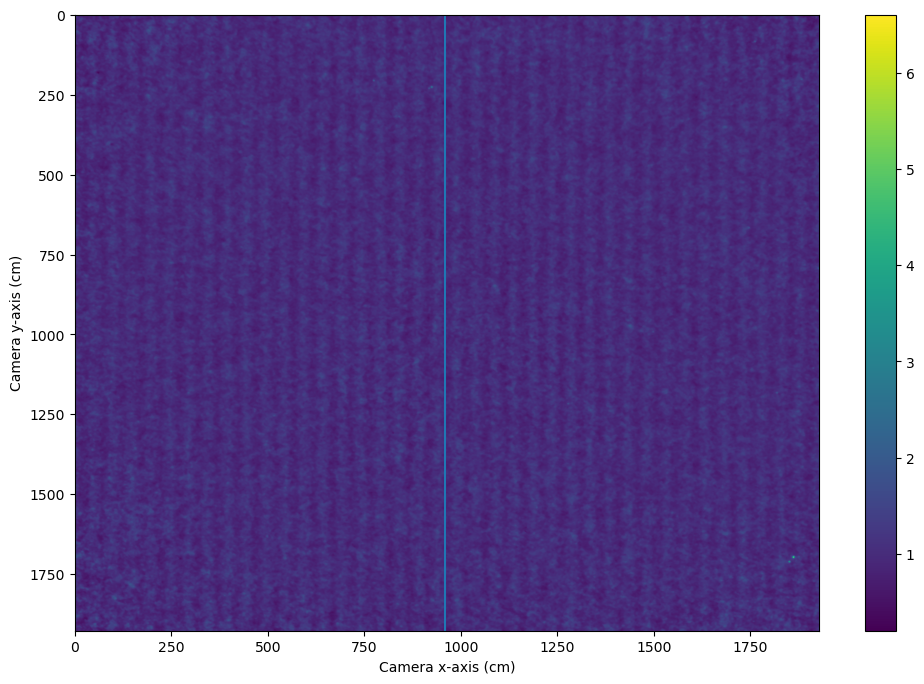

In [1048]:
fig, ax1 = plt.subplots(figsize = (12,8))




c = ax1.imshow(exp1filtered[1,5], aspect = "auto")

ax1.axvline(960)
# plt.xlim(700,1200)
fig.colorbar(c)

ax1.set_xlabel("Camera x-axis (cm)")
ax1.set_ylabel("Camera y-axis (cm)")

fig.savefig("sample.jpg")

plt.show()
plt.close(fig)

In [71]:
t0 = time()

# camx, camy = np.linspace(0, xlen_pxl, allfiltregions.shape[-1]) * cm_per_pixel *1e-2,\
#                 np.linspace(0, ylen_pxl, allfiltregions.shape[-2]) * cm_per_pixel*1e-2

# exp1slice = abs(np.nanmean(allfiltregions,axis = -2))



# Ldata = 8.2955
# ddata = np.linspace(4.5,44.5,21)*1e-3
# pdata = 3e-6
    



# jpdatafitted = np.empty(exp1slice.shape)
# jpdataparams = np.empty((*exp1slice.shape[:-1],4))

# for i in range(exp1slice.shape[0]):
#     for j in range(exp1slice.shape[1]):
#         for k in range(exp1slice.shape[2]):
#             profile = exp1slice[i,j,k]
#             jpdataparams[i,j,k] = best_fit_moire_period(cosine_func, camx, profile, pdata,Ldata,ddata[k])
#             jpdatafitted[i,j,k] = cosine_func(camx,*jpdataparams[i,j,k])


# datacont = np.mean(np.abs(jpdataparams[...,1]/jpdataparams[...,0]), axis = 0)
# datafreq = np.mean(1/(jpdataparams[...,2]), axis = 0)




camx, camy = np.linspace(0, exp1filtered.shape[-1], exp1filtered.shape[-1]) * cm_per_pixel *1e-2,\
                np.linspace(0, exp1filtered.shape[-2], exp1filtered.shape[-2]) * cm_per_pixel*1e-2

exp1slice = abs(np.nanmean(exp1filtered,axis = -2))



Ldata = 8.2955
ddata = np.linspace(4.5,44.5,21)*1e-3
pdata = 3e-6
    


jpdatafitted = np.empty(exp1slice.shape)
jpdataparams = np.empty((*exp1slice.shape[:-1],4))

for i in range(exp1slice.shape[0]):
    for j in range(exp1slice.shape[1]):
            profile = exp1slice[i,j]
            jpdataparams[i,j] = best_fit_moire_period(cosine_func, camx, profile, pdata,Ldata,ddata[j])
            jpdatafitted[i,j] = cosine_func(camx,*jpdataparams[i,j])


datacont = np.abs(jpdataparams[...,1]/jpdataparams[...,0])
datafreq = 1/(jpdataparams[...,2])
print(time() - t0, "seconds")

False
(6, 21, 1928)
19.691367387771606 seconds


In [72]:
camx

array([0.00000000e+00, 3.08802142e-05, 6.17604285e-05, ...,
       5.94444124e-02, 5.94752926e-02, 5.95061728e-02])

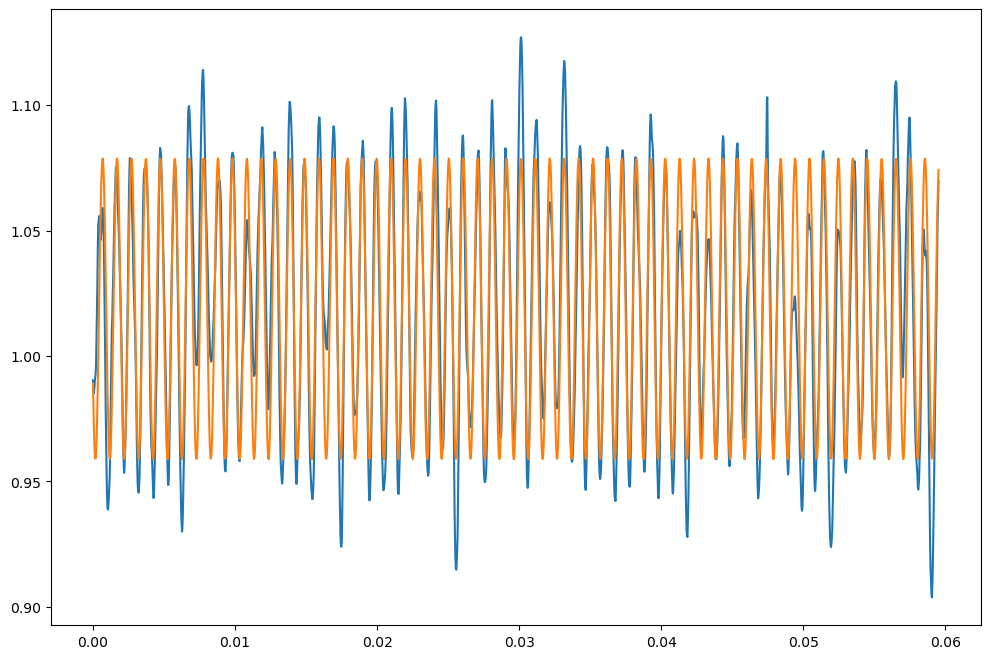

In [73]:
fig, ax1 = plt.subplots(figsize = (12,8))
ax1.plot(camx,exp1slice[3,9])
ax1.plot(camx,jpdatafitted[3,9])
# ax1.plot(ddata,datacont[monoindices[1]])

plt.show()

In [74]:
def lin_func(d,d0,L,L0,p):
    return (d - d0)/((L-L0)*p)

def get_outlier_mask(data_arr,outlier_indices):
    mask = np.full(data_arr.shape,True)
    for i in range(data_arr.shape[0]):
        for ind in outlier_indices[i]:
            mask[i,ind] = False
    return mask


# def lin_func(d,d0):
#     return (d - d0)/((8.2955+0.309088)*3e-6)

In [81]:


runs = [re.findall('[0-9]+', i)[0] for i in os.listdir(exp1path)]

monoindices = [runs.index(i) for i in runs if int(i) % 4 == 0]

cont5pcmaskmono = datacont[monoindices] > 0.05

monodatafreq = datafreq[monoindices]


d0mono, L0mono = np.array([curve_fit(lambda d,d0,L0: lin_func(d,d0,Ldata,L0,pdata), ddata[cont5pcmaskmono[i]], monodatafreq[i,cont5pcmaskmono[i]], p0 = [-2e-3,-10e-2],\
                    maxfev = 10000)[0] for i, monoind in enumerate(monoindices)]).T


# print("d0 (mm): ", d0mono*1e3)

polyindices = [runs.index(i) for i in runs if int(i)%2 != 0]

polydatafreq = datafreq[polyindices]

cont5pcmaskpoly = datacont[polyindices] > 0.05


d0poly, L0poly = np.array([curve_fit(lambda d,d0, L0: lin_func(d,d0,Ldata,L0,pdata),ddata[cont5pcmaskpoly[i]], polydatafreq[i,cont5pcmaskpoly[i]], p0 = [-2e-3,-10e-2],\
                    maxfev = 10000)[0] for i, polyind in enumerate(polyindices)]).T

# print("d0 (mm): ", d0poly*1e3)

L0data = np.mean([L0mono,L0poly])

d0mono = np.array([curve_fit(lambda d,d0: lin_func(d,d0,Ldata,L0data,pdata), ddata[cont5pcmaskmono[i]], monodatafreq[i,cont5pcmaskmono[i]], p0 = [-2e-3],\
                    maxfev = 10000)[0] for i, monoind in enumerate(monoindices)]).squeeze()
d0poly = np.array([curve_fit(lambda d,d0: lin_func(d,d0,Ldata,L0data,pdata),ddata[cont5pcmaskpoly[i]], polydatafreq[i,cont5pcmaskpoly[i]], p0 = [-2e-3],\
                    maxfev = 10000)[0] for i, polyind in enumerate(polyindices)]).squeeze()

# print("d0 (mm): ", d0mono*1e3)

# print("d0 (mm): ", d0poly*1e3)

d0data = np.mean([d0mono,d0poly], axis = 0)

print(d0data*1e3)


[-1.90181638 -2.17649256 -1.646649  ]


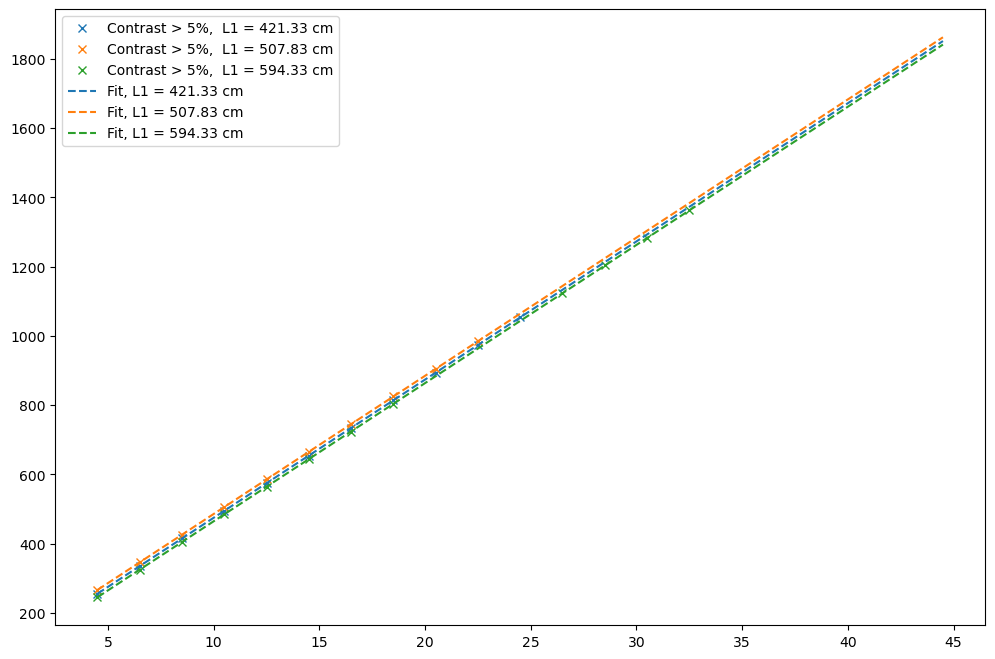

In [94]:
fig, ax1 = plt.subplots(figsize = (12,8))

# [ax1.plot(ddata*1e3,monodatafreq[i],"x", label = "Data, L1 = %.2f cm" % (L1jp.squeeze()[0,i] * 1e2)) for i, monoind in enumerate(monoindices)]
# ax1.set_prop_cycle(None)

[ax1.plot(ddata[cont5pcmaskmono[i]]*1e3,monodatafreq[i][cont5pcmaskmono[i]],"x", label = "Contrast > 5%%,  L1 = %.2f cm" % (L1jp.squeeze()[0,i] * 1e2)) for i, monoind in enumerate(monoindices)]

ax1.set_prop_cycle(None)

[ax1.plot(ddata*1e3,lin_func(ddata,d0mono[i],Ldata,L0data,pdata),"--", label = "Fit, L1 = %.2f cm" % (L1jp.squeeze()[0,i] * 1e2)) for i, monoind in enumerate(monoindices)]


ax1.legend()

plt.show()
plt.close(fig)

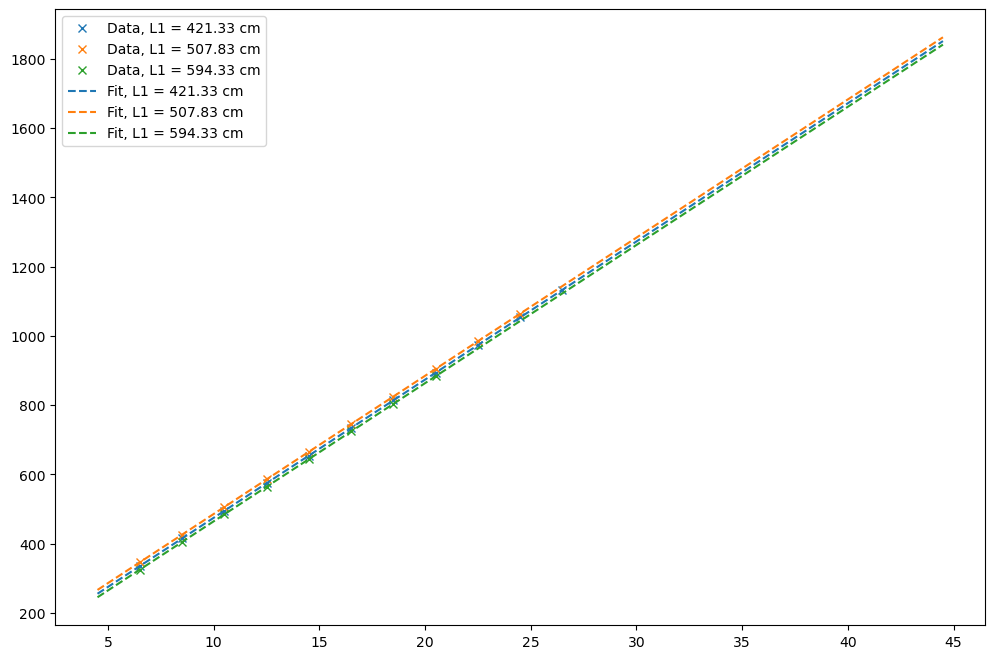

In [92]:


fig, ax1 = plt.subplots(figsize = (12,8))

# [ax1.plot(ddata*1e3,polydatafreq[i],"x", label = "Data, L1 = %.2f cm" % (L1jp.squeeze()[i] * 1e2)) for i, polyind in enumerate(polyindices)]


[ax1.plot(ddata[cont5pcmaskpoly[i]]*1e3,polydatafreq[i][cont5pcmaskpoly[i]],"x", label = "Data, L1 = %.2f cm" % (L1jp.squeeze()[0,i] * 1e2)) for i, polyind in enumerate(polyindices)]

ax1.set_prop_cycle(None)

[ax1.plot(ddata*1e3,lin_func(ddata,d0poly[i],Ldata,L0data,pdata),"--", label = "Fit, L1 = %.2f cm" % (L1jp.squeeze()[0,i] * 1e2)) for i, polyind in enumerate(polyindices)]

ax1.legend()
# plt.xlim(24,47)
# plt.ylim(800,1900)
plt.show()



### JPARC Simulations


In [358]:
TOF, TOFcounts = np.array(pd.read_excel("neutronTOF_run19771.xlsx", usecols = (2,3),skiprows = (0,1))).T
TOF, TOFcounts = TOF[::4], TOFcounts[::4]

TOF *= 1e-3
TOFcountsarea = np.trapz(TOFcounts) # area under curve
TOFcountsnormed = TOFcounts/TOFcountsarea # sum is 1

TOF = TOF[TOFcountsnormed > 2e-4]
jpplam = TOFcountsnormed[TOFcountsnormed > 2e-4]

def TOFtolambda(TOF, planck_const, mass, detector_dist):
    return TOF * planck_const / (mass * detector_dist)


m_neu = 1.6749275e-27
planck_const = 6.6261e-34
detector_dist = 23.854



jplam = TOFtolambda(TOF, planck_const, m_neu, detector_dist)

cutout_mask = (jplam >= 5e-10) & (jplam <= 6e-10)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


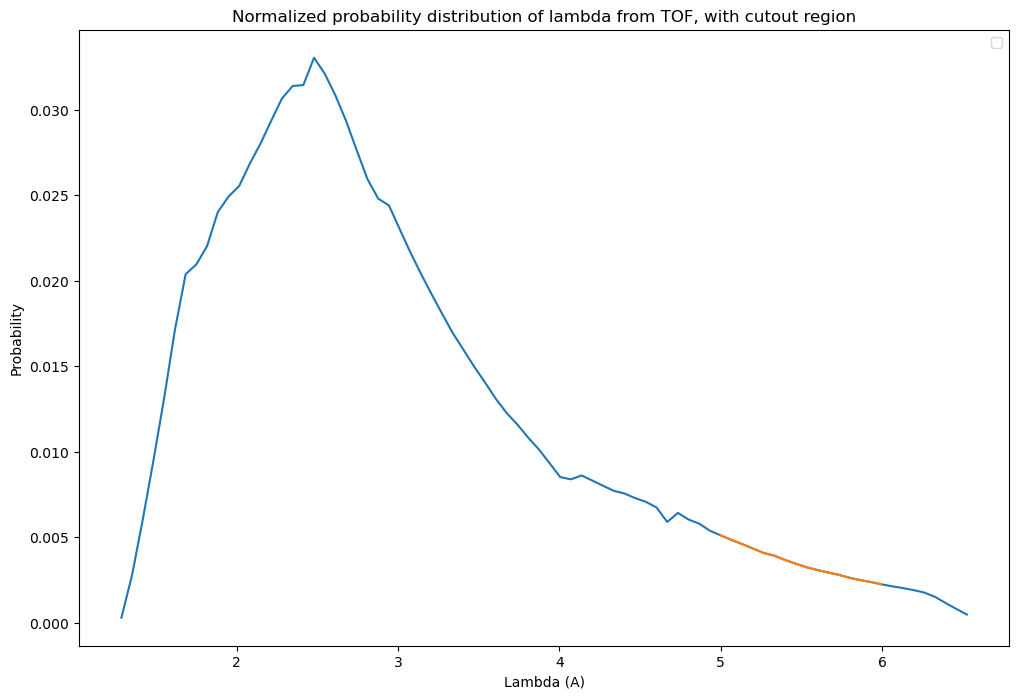

In [359]:
fig, ax1 = plt.subplots(figsize  = (12,8))

ax1.plot(jplam*1e10, jpplam)
ax1.plot(jplam[cutout_mask]*1e10, jpplam[cutout_mask])


# plt.xlim(4.5,6.1)
ax1.set_xlabel("Lambda (A)")
ax1.set_ylabel("Probability")
ax1.set_title("Normalized probability distribution of lambda from TOF, with cutout region")
ax1.legend()
# fig.savefig("jplamdist.jpg")
plt.show()
plt.close(fig)

In [88]:
L0data

-0.05728870141376715

In [906]:
Nbc = 5e28*4.149e-15
mt = 5
x0 = 0

pjp = 3e-6
xbinjp = 1e-6
ybinjp = 1e-6

jpmonolam = jplam[cutout_mask]
jpmonoplam = jpplam[cutout_mask]


hjp = 8.53e-6
jpd = np.linspace(4.5,44.5,51)*1e-3 


L0mono = L0data

a_vals = np.linspace(-20,20,11)*1e-2


L1jp = (96.6 + 319)*1e-2 +  np.arange(0,3,1) * 0.865 - L0mono 



jpd,L1jp = force_broadcast(jpd,L1jp)



L1jp = L1jp - (jpd - jpd[0])/2

Ljp = 8.2955 - L0mono



monophijp = Nbc*jpmonolam*hjp



jpcamsize = 1e-2
# jpslit = 750e-6

jpslits = np.linspace(300,700,21)*1e-6
print(jpslits)

jpres = 100e-6
# res_vals = np.linspace(100,200,6)*1e-6



G1monosd = {"p":pjp, "L1": L1jp, "phi":monophijp}
G1monosd["L2"] = jpd


G2monosd = {"p":pjp, "L1": G1monosd["L1"] +  G1monosd["L2"], "phi":monophijp}
G2monosd["L2"] = Ljp - G2monosd["L1"]
# print(G2monosd["L2"])

# Ioff = np.array([1000])
Ioff = np.array([0])

simjpmonoapts = {"G1":RectGrating(G1monosd),"G2":RectGrating(G2monosd)}



simjpmonoinit = {"lam":jpmonolam, "plam" : jpmonoplam, "L":np.array([Ljp]),"d":G1monosd["L2"],"mt":mt, \
                 "x": np.linspace(0,jpcamsize,int(jpcamsize/xbinjp) + 1),"x0" : x0,"xbin":xbinjp,\
                 "y": np.linspace(0,jpcamsize,int(jpcamsize/ybinjp) + 1),"ybin":ybinjp,"pos":np.array([[0],[1]]),"camsize" : jpcamsize ,\
                 "convmode" : "valid", "slitx": jpslit, "slity" : jpslit, "res": jpres, "batches": 2000, "Ioffset": Ioff }



[0.0003  0.00032 0.00034 0.00036 0.00038 0.0004  0.00042 0.00044 0.00046
 0.00048 0.0005  0.00052 0.00054 0.00056 0.00058 0.0006  0.00062 0.00064
 0.00066 0.00068 0.0007 ]


In [907]:
print(jpslits)
print(a_vals)
print(Ljp)

[0.0003  0.00032 0.00034 0.00036 0.00038 0.0004  0.00042 0.00044 0.00046
 0.00048 0.0005  0.00052 0.00054 0.00056 0.00058 0.0006  0.00062 0.00064
 0.00066 0.00068 0.0007 ]
[-0.2  -0.16 -0.12 -0.08 -0.04  0.    0.04  0.08  0.12  0.16  0.2 ]
8.352788701413768


In [1047]:
t0 = time()

# simjpmono = PGMI(simjpmonoapts,simjpmonoinit)
# simjpmono.propagate_to("G1")
# simjpmono.propagate_to("G2")
# simjpmono.generate_after("G2")


# contjpmonoslit = []
# fitparamsjpmonoslit = []

# contjpmonoaslit = []
# fitparamsjpmonoaslit = []

# contjpmonores = []
# fitparamsjpmonores = []

# for slit in jpslits:
    
#     simjpmonoinit["slitx"] = slit
#     simjpmono = PGMI(simjpmonoapts,simjpmonoinit)
#     simjpmono.propagate_to("G1")
#     simjpmono.propagate_to("G2")
#     simjpmono.generate_after("G2")
#     contjpmonoslit.append(simjpmono.get_value("contrast"))
#     fitparamsjpmonoslit.append(simjpmono.get_value("fitparams"))


# for a in a_vals:
#     L1 = L1jp - a
#     G1monosd = {"p":pjp, "L1": L1, "phi":monophijp}
#     G1monosd["L2"] = jpd
    

#     G2monosd = {"p":pjp, "L1": G1monosd["L1"] +  G1monosd["L2"], "phi":monophijp}
#     G2monosd["L2"] = Ljp - G2monosd["L1"]
#     simjpmonoapts = {"G1":RectGrating(G1monosd),"G2":RectGrating(G2monosd)}

    
#     for slit in jpslits:
        
#         contjpmonoaslit.append([])
#         fitparamsjpmonoaslit.append([])
#         simjpmonoinit["slitx"] = slit


#         simjpmono = PGMI(simjpmonoapts,simjpmonoinit)
#         simjpmono.propagate_to("G1")
#         simjpmono.propagate_to("G2")
#         simjpmono.generate_after("G2")
#         contjpmonoaslit[-1].append(simjpmono.get_value("contrast"))
#         fitparamsjpmonoaslit[-1].append(simjpmono.get_value("fitparams"))

# for res in res_vals:
    
#     simjpmonoinit["res"] = res
#     simjpmono = PGMI(simjpmonoapts,simjpmonoinit)
#     simjpmono.propagate_to("G1")
#     simjpmono.propagate_to("G2")
#     simjpmono.generate_after("G2")
#     contjpmonores.append(simjpmono.get_value("contrast"))
#     fitparamsjpmonores.append(simjpmono.get_value("fitparams"))
    
print(time() - t0, "seconds")

0.0 seconds


In [1046]:
print(fitparamsjpmonoaslit)

(231, 51, 3, 4)


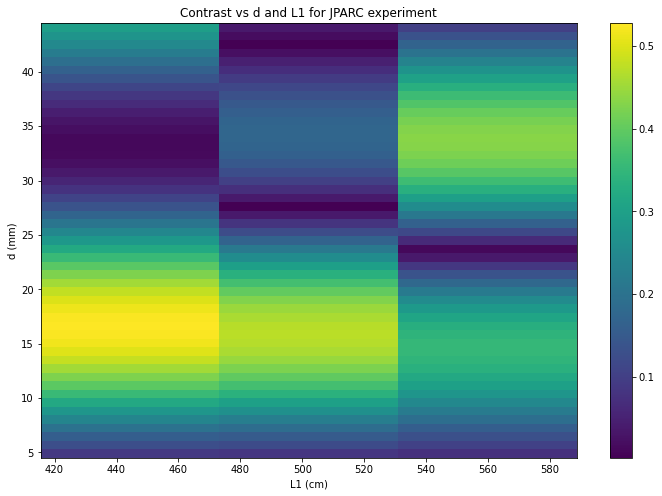

In [ ]:
fig, ax1 = plt.subplots(figsize = (12,8))

c = ax1.imshow(contjpmono, aspect = "auto", origin = "lower",extent = (L1jp.squeeze()[0]*1e2,L1jp.squeeze()[-1]*1e2,jpd.squeeze()[0]*1e3,jpd.squeeze()[-1]*1e3))



# c = ax1.imshow(Ijp, extent = (simjp.x[0]*1e3, simjp.x[-1]*1e3, simjp.y[0]*1e3, simjp.y[-1]*1e3), origin = "lower")

# c = ax1.imshow(Ijp[0], extent = (simjp.x[0]*1e3, simjp.x[-1]*1e3, simjp.y[0]*1e3, simjp.y[-1]*1e3), origin = "lower")
fig.colorbar(c)

ax1.set_xlabel("L1 (cm)")
ax1.set_ylabel("d (mm)")
ax1.set_title("Contrast vs d and L1 for JPARC experiment")
# fig.savefig("contjpL1d.jpg")
plt.show()

In [1013]:
Nbc = 5e28*4.149e-15


jppolylam = jplam.copy()
jppolyplam = jpplam.copy()


polyphijp = Nbc*jppolylam*hjp





G1polysd = {"p":pjp, "L1": L1jp - a_vals[np.array((9,9,10))], "phi":polyphijp}
G1polysd["L2"] = jpd


G2polysd = {"p":pjp, "L1": G1polysd["L1"] +  G1polysd["L2"], "phi":polyphijp}
G2polysd["L2"] = Ljp - G2polysd["L1"]


# Ioff = np.array([500])



simjppolyapts = {"G1":RectGrating(G1polysd),"G2":RectGrating(G2polysd)}

simjppolyinit = {"lam":jppolylam, "plam" : jppolyplam, "L":Ljp,"d":G1polysd["L2"],"mt":mt, "x": np.linspace(0,jpcamsize,int(jpcamsize/xbinjp) + 1),"x0" : x0,"xbin":xbinjp,\
            "y": np.linspace(0,jpcamsize,int(jpcamsize/ybinjp) + 1),"ybin":ybinjp,"pos":np.array([[0],[1]]),\
            "camsize" : jpcamsize ,"convmode" : "valid", "slitx": jpslits[10], "slity" : jpslits[10], "res": jpres, "batches": 2000, "Ioffset" : Ioff }


In [1014]:
t0 = time()
simjppoly = PGMI(simjppolyapts,simjppolyinit)
simjppoly.propagate_to("G1")
simjppoly.propagate_to("G2")
simjppoly.generate_after("G2")


# contjppolyslit = []
# fitparamsjppolyslit = []

# contjppolyaslit = []
# fitparamsjppolyaslit = []

# contjppolyres = []
# fitparamsjppolyres = []

# for slit in jpslits:
    
#     simjppolyinit["slitx"] = slit
#     simjppoly = PGMI(simjppolyapts,simjppolyinit)
#     simjppoly.propagate_to("G1")
#     simjppoly.propagate_to("G2")
#     simjppoly.generate_after("G2")
#     contjppolyslit.append(simjppoly.get_value("contrast"))
#     fitparamsjppolyslit.append(simjppoly.get_value("fitparams"))


# for a in a_vals:
#     L1 = L1jp - a
#     G1polysd = {"p":pjp, "L1": L1, "phi":polyphijp}
#     G1polysd["L2"] = jpd


#     G2polysd = {"p":pjp, "L1": G1polysd["L1"] +  G1polysd["L2"], "phi":polyphijp}
#     G2polysd["L2"] = Ljp - G2polysd["L1"]
        
#     simjppolyapts = {"G1":RectGrating(G1polysd),"G2":RectGrating(G2polysd)}
    
#     for slit in jpslits:
#         contjppolyaslit.append([])
#         fitparamsjppolyaslit.append([])
#         simjppolyinit["slitx"] = slit

#         simjppoly = PGMI(simjppolyapts,simjppolyinit)
#         simjppoly.propagate_to("G1")
#         simjppoly.propagate_to("G2")
#         simjppoly.generate_after("G2")
#         contjppolyaslit[-1].append(simjppoly.get_value("contrast"))
#         fitparamsjppolyaslit[-1].append(simjppoly.get_value("fitparams"))

# for res in res_vals:
    
#     simjppolyinit["res"] = res
#     simjppoly = PGMI(simjppolyapts,simjppolyinit)
#     simjppoly.propagate_to("G1")
#     simjppoly.propagate_to("G2")
#     simjppoly.generate_after("G2")
#     contjppolyres.append(simjppoly.get_value("contrast"))
#     fitparamsjppolyres.append(simjppoly.get_value("fitparams"))
    
print(time() - t0, "seconds")

0.0005
(2000, 51, 3, 80, 5) after parallel
(51, 3, 80, 10000) after reshape
(51, 3, 10000) before convolution
Finding contrast
385.1725687980652 seconds


In [1015]:
# Ijpmono = simjpmono.get_value("intensity")
# rawjpmono = simjpmono.get_value("raw")
# contjpmono = simjpmono.get_value("contrast")
# fitparamsjpmono = simjpmono.get_value("fitparams")
# simfreqjpmono = 1/np.abs(fitparamsjpmono[...,2]) 


Ijppoly = simjppoly.get_value("intensity")
rawjppoly = simjppoly.get_value("raw")
contjppoly = simjppoly.get_value("contrast")
fitparamsjppoly = simjppoly.get_value("fitparams")
simfreqjppoly = 1/np.abs(fitparamsjppoly[...,2]) 


In [909]:
# contjpmonoslit, fitparamsjpmonoslit = np.array([contjpmonoslit]).squeeze(), np.array([fitparamsjpmonoslit]).squeeze()
# simfreqjpmonoslit = 1/np.abs(fitparamsjpmonoslit[...,2])
# contjppolyslit, fitparamsjppolyslit = np.array([contjppolyslit]).squeeze(), np.array([fitparamsjppolyslit]).squeeze()
# simfreqjppolyslit = 1/np.abs(fitparamsjppolyslit[...,2])

# contjpmonoa, fitparamsjpmonoa = np.array([contjpmonoa]).squeeze(), np.array([fitparamsjpmonoa]).squeeze()
# simfreqjpmonoa = 1/np.abs(fitparamsjpmonoa[...,2])
# contjppolya, fitparamsjppolya = np.array([contjppolya]).squeeze(), np.array([fitparamsjppolya]).squeeze()
# simfreqjppolya = 1/np.abs(fitparamsjppolya[...,2])

# contjpmonores, fitparamsjpmonores = np.array([contjpmonores]).squeeze(), np.array([fitparamsjpmonores]).squeeze()
# simfreqjpmonores = 1/np.abs(fitparamsjpmonores[...,2])
# contjppolyres, fitparamsjppolyres = np.array([contjppolyres]).squeeze(), np.array([fitparamsjppolyres]).squeeze()
# simfreqjppolyres = 1/np.abs(fitparamsjppolyres[...,2])

contjpmonoaslit, fitparamsjpmonoaslit = np.array([contjpmonoaslit]).squeeze(), np.array([fitparamsjpmonoaslit]).squeeze()
simfreqjpmonoaslit = 1/np.abs(fitparamsjpmonoaslit[...,2])
contjppolyaslit, fitparamsjppolyaslit = np.array([contjppolyaslit]).squeeze(), np.array([fitparamsjppolyaslit]).squeeze()
simfreqjppolyaslit = 1/np.abs(fitparamsjppolyaslit[...,2])

In [910]:
print(contjpmonoaslit.shape)

(231, 51, 3)


In [1009]:
jpslits[10]

0.0005

In [912]:
contjpmonoaslit = contjpmonoaslit.reshape(11,21,51,3)
simfreqjpmonoaslit = simfreqjpmonoaslit.reshape(11,21,51,3)


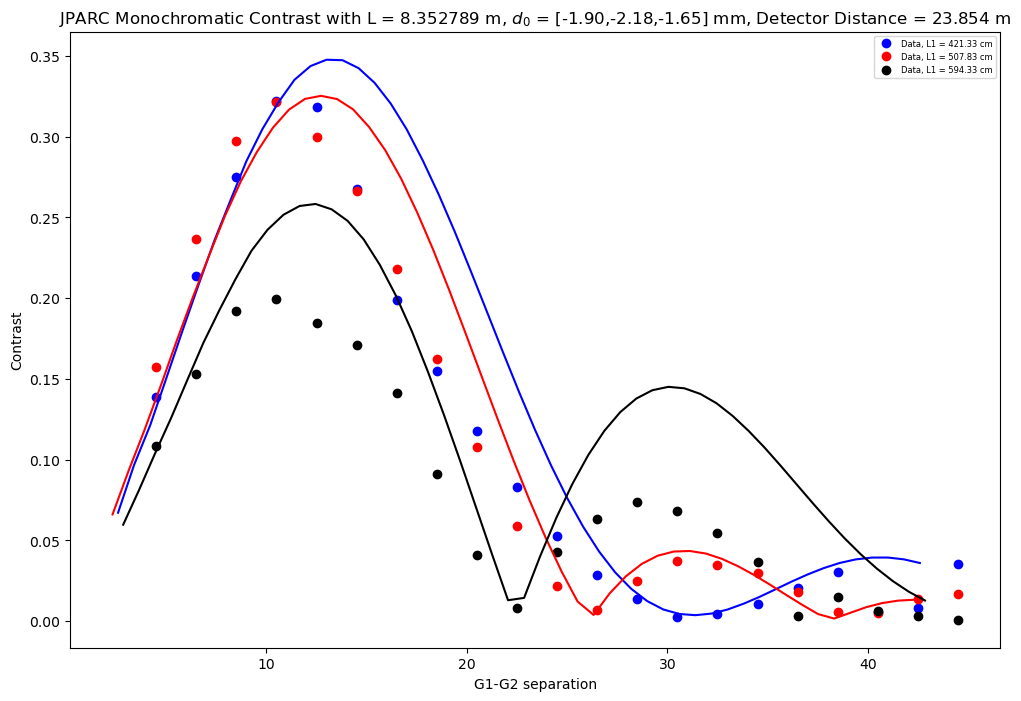

In [1041]:
fig, ax1 = plt.subplots(figsize = (12,8))

markers = ["1","<","o","v","p","h","+",">", "d", "2", "3"]



ax1.set_prop_cycle(color = ["blue","red","black"])

for i, monoind in enumerate(monoindices):
    ax1.plot(ddata*1e3, datacont[monoind], "o", label = "Data, L1 = %.2f cm" % (L1jp.squeeze()[0,i] * 1e2) )

    
ax1.set_prop_cycle(color = ["blue","red","black"])

# for slitind, slit in enumerate(jpslits):
#     for i, monoind in enumerate(monoindices):
#         ax1.plot((jpd + d0data[i])*1e3, contjpmonoslit[slitind,:,i],markers[slitind] + "-" ,\
#             label = "Simulation, L1 = %.2f cm, slit size %.f um" % (L1jp.squeeze()[0,i] * 1e2, slit*1e6))
#     ax1.set_prop_cycle(color = ["blue","red","black"])

# for aind, a in enumerate(a_vals):
#     for i, monoind in enumerate(monoindices):
#         ax1.plot((jpd + d0data[i])*1e3, contjpmonoa[aind,:,i],markers[aind] + "-" ,\
#             label = "Simulation, L1 = %.2f cm, a = %.f cm" % (L1jp.squeeze()[0,i] * 1e2, a*1e2))
#     ax1.set_prop_cycle(color = ["blue","red","black"])


# [ax1.plot((jpd + d0data[i])*1e3, contjpmono[:,i], label = "Simulation, L1 = %.2f cm" % (L1jp.squeeze()[0,i] * 1e2)) for i, monoind in enumerate(monoindices)]


# for resind, res in enumerate(res_vals):
#     for i, monoind in enumerate(monoindices):
#         ax1.plot((jpd + d0data[i])*1e3, contjpmonores[resind,:,i],markers[resind] + "-" ,\
#             label = "Simulation, L1 = %.2f cm, res size %.f um" % (L1jp.squeeze()[0,i] * 1e2, res*1e6))
#     ax1.set_prop_cycle(color = ["blue","red","black"])



scale = 0.75
    
    
ax1.plot((jpd + d0data[0])*1e3, contjpmonoaslit[9,10,:,0]*scale )
ax1.plot((jpd + d0data[1])*1e3, contjpmonoaslit[9,10,:,1]*scale )
ax1.plot((jpd + d0data[2])*1e3, contjpmonoaslit[10,10,:,2]*scale )

ax1.set_title(r"JPARC Monochromatic Contrast with L = %f m, $d_0$ = [%.2f,%.2f,%.2f] mm, Detector Distance = %.3f m" % (Ljp, *(d0data*1e3), detector_dist))
ax1.set_xlabel("G1-G2 separation")
ax1.set_ylabel("Contrast")
ax1.legend(fontsize = 6)
fig.savefig("jparcmonocontoptimal.jpg")
plt.show()

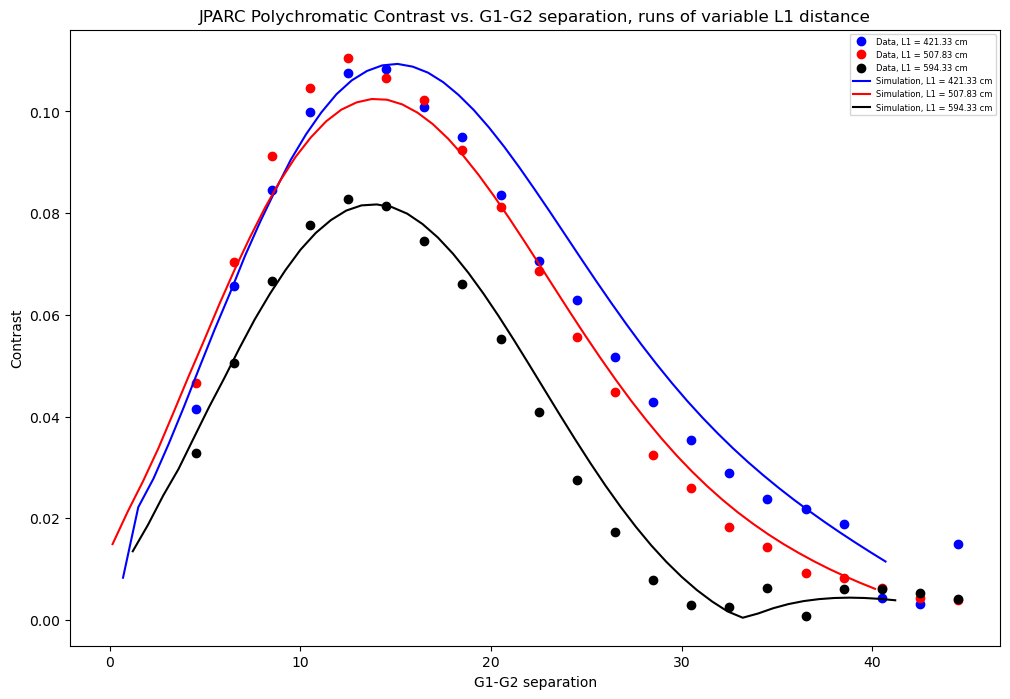

In [1042]:
fig, ax1 = plt.subplots(figsize = (12,8))




ax1.set_prop_cycle(color = ["blue","red","black"])

for i, polyind in enumerate(polyindices):
    ax1.plot(ddata*1e3, datacont[polyind], "o", label = "Data, L1 = %.2f cm" % (L1jp.squeeze()[0,i] * 1e2) )
    
# ax1.set_prop_cycle(color = ["blue","red","black"])

# for slitind, slit in enumerate(jpslits):
#     for i, polyind in enumerate(polyindices):
#             ax1.plot((jpd + d0data[i])*1e3, contjppolyslit[slitind,:,i],markers[slitind] + "-" ,\
#                  label = "Simulation, L1 = %.2f cm, slit size %.f um" % (L1jp.squeeze()[0,i] * 1e2, slit*1e6))
#     ax1.set_prop_cycle(color = ["blue","red","black"])

# for aind, a in enumerate(a_vals):
#     for i, polyind in enumerate(polyindices):
#         ax1.plot((jpd + d0data[i])*1e3, contjppolya[aind,:,i],markers[aind] + "-" ,\
#             label = "Simulation, L1 = %.2f cm, a = %.f cm" % (L1jp.squeeze()[0,i] * 1e2, a*1e2))
#     ax1.set_prop_cycle(color = ["blue","red","black"])


[ax1.plot((jpd + 2*d0data[i])*1e3, contjppoly[:,i]*0.85, label = "Simulation, L1 = %.2f cm" % (L1jp.squeeze()[0,i] * 1e2)) for i, polyind in enumerate(polyindices)]

# for resind, res in enumerate(res_vals):
#     for i, polyind in enumerate(polyindices):
#         ax1.plot((jpd + d0data[i])*1e3, contjppolyres[resind,:,i],markers[resind] + "-" ,\
#             label = "Simulation, L1 = %.2f cm, res size %.f um" % (L1jp.squeeze()[0,i] * 1e2, res*1e6))
#     ax1.set_prop_cycle(color = ["blue","red","black"])




    
# ax1.plot((jpd + d0data[0])*1e3, contjppolyaslit[5,6,:,0],markers[6] + "-" )
# ax1.plot((jpd + d0data[1])*1e3, contjppolyaslit[10,6,:,1],markers[6] + "-" )
# ax1.plot((jpd + d0data[2])*1e3, contjppolyaslit[6,6,:,2],markers[6] + "-" )
    
    

ax1.set_title("JPARC Polychromatic Contrast vs. G1-G2 separation, runs of variable L1 distance")
ax1.set_xlabel("G1-G2 separation")
ax1.set_ylabel("Contrast")
ax1.legend(fontsize = 6)
fig.savefig("jparcpolycontoptimal.jpg")
plt.show()

In [1043]:
[10]

0.0005

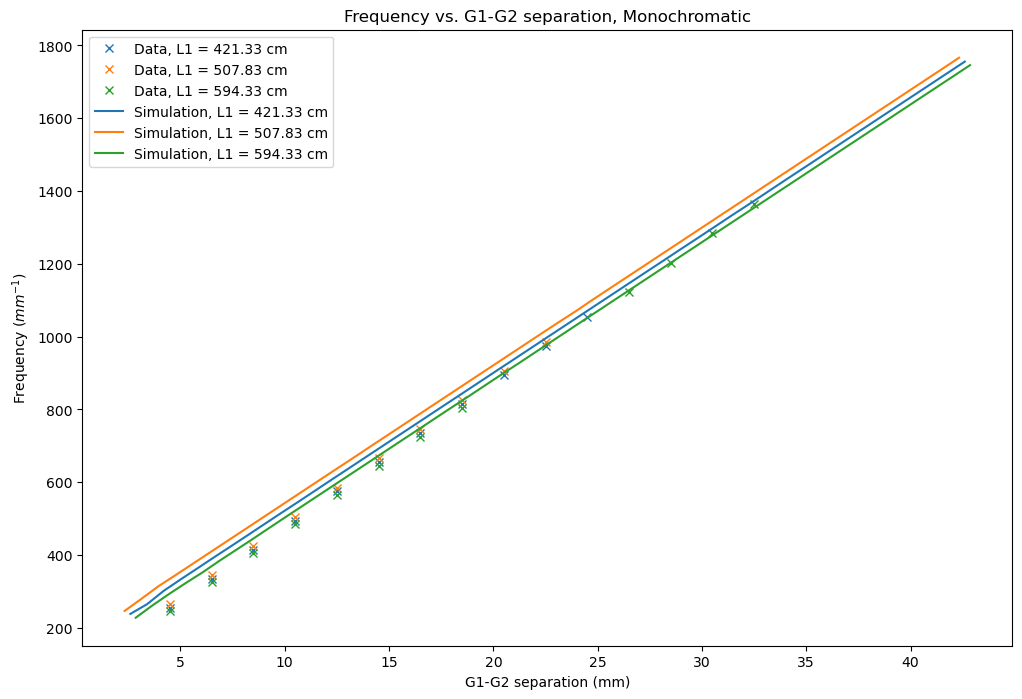

In [1036]:
fig, ax1 = plt.subplots(figsize = (12,8))




[ax1.plot(ddata[cont5pcmaskmono[i]]*1e3,datafreq[monoind,:][cont5pcmaskmono[i]],"x", label = "Data, L1 = %.2f cm" % (L1jp.squeeze()[0,i] * 1e2)) for i, monoind in enumerate(monoindices)]
plt.gca().set_prop_cycle(None)

ax1.plot((jpd.squeeze() + d0data[0])*1e3,simfreqjpmonoaslit[4,6,:,0]*(1 - (d0data[0]/jpd).squeeze()), label = "Simulation, L1 = %.2f cm" % (L1jp.squeeze()[0,0] * 1e2))
ax1.plot((jpd.squeeze() + d0data[1])*1e3,simfreqjpmonoaslit[0,6,:,1]*(1 - (d0data[1]/jpd).squeeze()), label = "Simulation, L1 = %.2f cm" % (L1jp.squeeze()[0,1] * 1e2))
ax1.plot((jpd.squeeze() + d0data[2])*1e3,simfreqjpmonoaslit[6,6,:,2]*(1 - (d0data[2]/jpd).squeeze()), label = "Simulation, L1 = %.2f cm" % (L1jp.squeeze()[0,2] * 1e2))




ax1.set_title(r"Frequency vs. G1-G2 separation, Monochromatic")
ax1.set_xlabel("G1-G2 separation (mm)")
ax1.set_ylabel(r"Frequency $(mm^{-1})$")
# ax1.text(20,1.2,"$R^2 = %.2f$" % r2)
ax1.legend()

# fig.savefig("monofreqvsdjpL0d0.jpg")

plt.show()

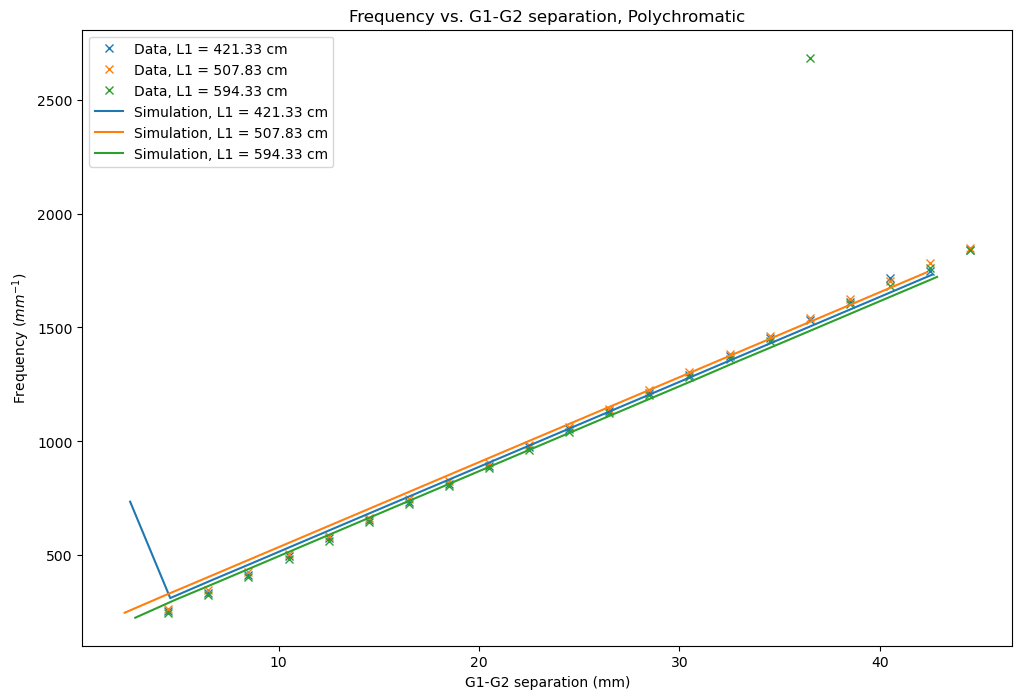

In [279]:
fig, ax1 = plt.subplots(figsize = (12,8))


[ax1.plot(ddata*1e3,datafreq[polyind,:],"x", label = "Data, L1 = %.2f cm" % (L1jp.squeeze()[0,i] * 1e2)) for i, polyind in enumerate(polyindices)]
plt.gca().set_prop_cycle(None)

[ax1.plot((jpd.squeeze() + d0data[i])*1e3,simfreqjppoly[:,i]*(1 - (d0data[i]/jpd).squeeze()), label = "Simulation, L1 = %.2f cm" % (L1jp.squeeze()[0,i] * 1e2))\
 for i, monoind in enumerate(polyindices)]


ax1.set_title(r"Frequency vs. G1-G2 separation, Polychromatic")
ax1.set_xlabel("G1-G2 separation (mm)")
ax1.set_ylabel(r"Frequency $(mm^{-1})$")
# ax1.text(20,1.2,"$R^2 = %.2f$" % r2)
ax1.legend()

# fig.savefig("polyfreqvsdjp.jpg")

plt.show()